# **Detection and Classification of Brain Tumor through Brain MRI Images Using Deep Learning**  

![Brain MRI Images Cover Photo](https://github.com/AnasRouam/Brain-MRI-Image-Classification-Using-Deep-Learning/blob/main/gettyimages-brain-mri.jpg?raw=1)

## **1.Introduction**  

* The occurrence of brain tumor patients in India is steadily rising,
more and more number of cases are reported each year in India across
various age groups.  

* The [International Association of Cancer Registries (IARC)](https://cutt.ly/Wc4DaIE) reported
that there are over $28,000$ cases of brain tumours reported in India
each year and more than $24,000$ people reportedly i.e. $85.72\%$ of the
total reported die due to brain tumours annually. Brain tumour’s are
a serious condition and in most cases fatal if not detected & treated
in early stages.



## **2. Setting Up Local Storage for Dataset**

### **2.1 Giving Access To Google Drive**

In [1]:

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### **2.2 Checking OS Version and Details**

In [2]:
print("OS Version & Details: ")
!lsb_release -a

OS Version & Details: 
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.5 LTS
Release:	22.04
Codename:	jammy


## **3. Importing Required Libraries**

In [3]:
!pip install missingno

In [4]:
import sys
import os
import math

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.15.0.


## **4. Setting Up the Environment**

In [5]:

gpu_device_location = tpu_device_location = cpu_device_location = None

if os.environ['COLAB_GPU'] == '1':
    print("Allocated GPU Runtime Details:")
    !nvidia-smi
    print()
    try:
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        gpu_device_name = pynvml.nvmlDeviceGetName(handle)

        if gpu_device_name not in ['Tesla T4', 'Tesla P4', 'Tesla P100-PCIE-16GB']:
            raise Exception("Unfortunately this instance does not have a T4, P4 or P100 GPU.\nSometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100.\nIf you get Tesla K80 then you can factory reset your runtime to get another GPUs.")
    except Exception as hardware_exception:
        print(hardware_exception, end = '\n\n')
    gpu_device_location = tf.test.gpu_device_name()
    print(f"{gpu_device_name.decode('utf-8')} is allocated sucessfully at location: {gpu_device_location}")
elif 'COLAB_TPU_ADDR' in os.environ:
    tpu_device_location = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
    print(f"TPU is allocated successfully at location: {tpu_device_location}.")
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_location)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy()
else:
    cpu_device_location = "/cpu:0"
    print("GPUs and TPUs are not allocated successfully, hence runtime fallbacked to CPU.")

GPUs and TPUs are not allocated successfully, hence runtime fallbacked to CPU.


### **4.1 Installation of `tree` Utility Using `Bash`.**  

In [6]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree
dpkg -s $pkg_name &> /dev/null
if [ "$?" -ne "0" ]
    then
        echo "Installing tree utility..."
        apt-get autoclean
        apt-get autoremove
        apt-get install $pkg_name
        if [ "$?" -eq "0" ]
            then
                echo -e ${RED_COLOR}"tree utility installed sucessfully.\n"${NO_COLOR}
        fi
    else
        echo "tree utility is already installed."
fi
tree --version

Installing tree utility...
Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (201 kB/s)
Selecting previously unselected package tree.
(Reading database ... 119628 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
tree utility installed sucessfully.

tree v2.0.2 (

### **4.2 Display of File Structure**

In [7]:
!tree -d "/content/gdrive/MyDrive/Colab Notebooks/BrainTumorDataset"

/content/gdrive/MyDrive/Colab Notebooks/BrainTumorDataset
├── Brain-Tumor-Dataset
│   ├── Brain-Tumor-Images-Mat-Files
│   ├── Testing
│   │   ├── No
│   │   └── Yes
│   ├── Training
│   │   ├── glioma
│   │   ├── meningioma
│   │   ├── no_tumor
│   │   └── pituitary_tumor
│   └── Tumor-Mask
│       ├── glioma
│       ├── meningioma
│       └── pituitary_tumor
└── Model-Checkpoints
    ├── AlexNet-CNN
    ├── InceptionV3
    └── Multi-Layer-Perceptron

18 directories


### **4.3 Setting Up Paths to Root and Data Directories**

In [8]:
ROOT_DIR = r"/content/gdrive/MyDrive/Colab Notebooks/BrainTumorDataset"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain-Tumor-Dataset")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')
assert os.path.isdir(ROOT_DIR) and os.path.isdir(DATA_ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(MASK_DIR)
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
MASK_DATA_PATHS = [os.path.join(MASK_DIR, tumor_name) for tumor_name in TUMOR_CLASS[:-1]]

## **5. Data Preprocessing and Exploratory Data Analysis**

In [9]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count

meningioma          708
glioma             1426
pituitary_tumor     930
no_tumor            395
dtype: int64

### **5.1 Data Distribution Visualization**

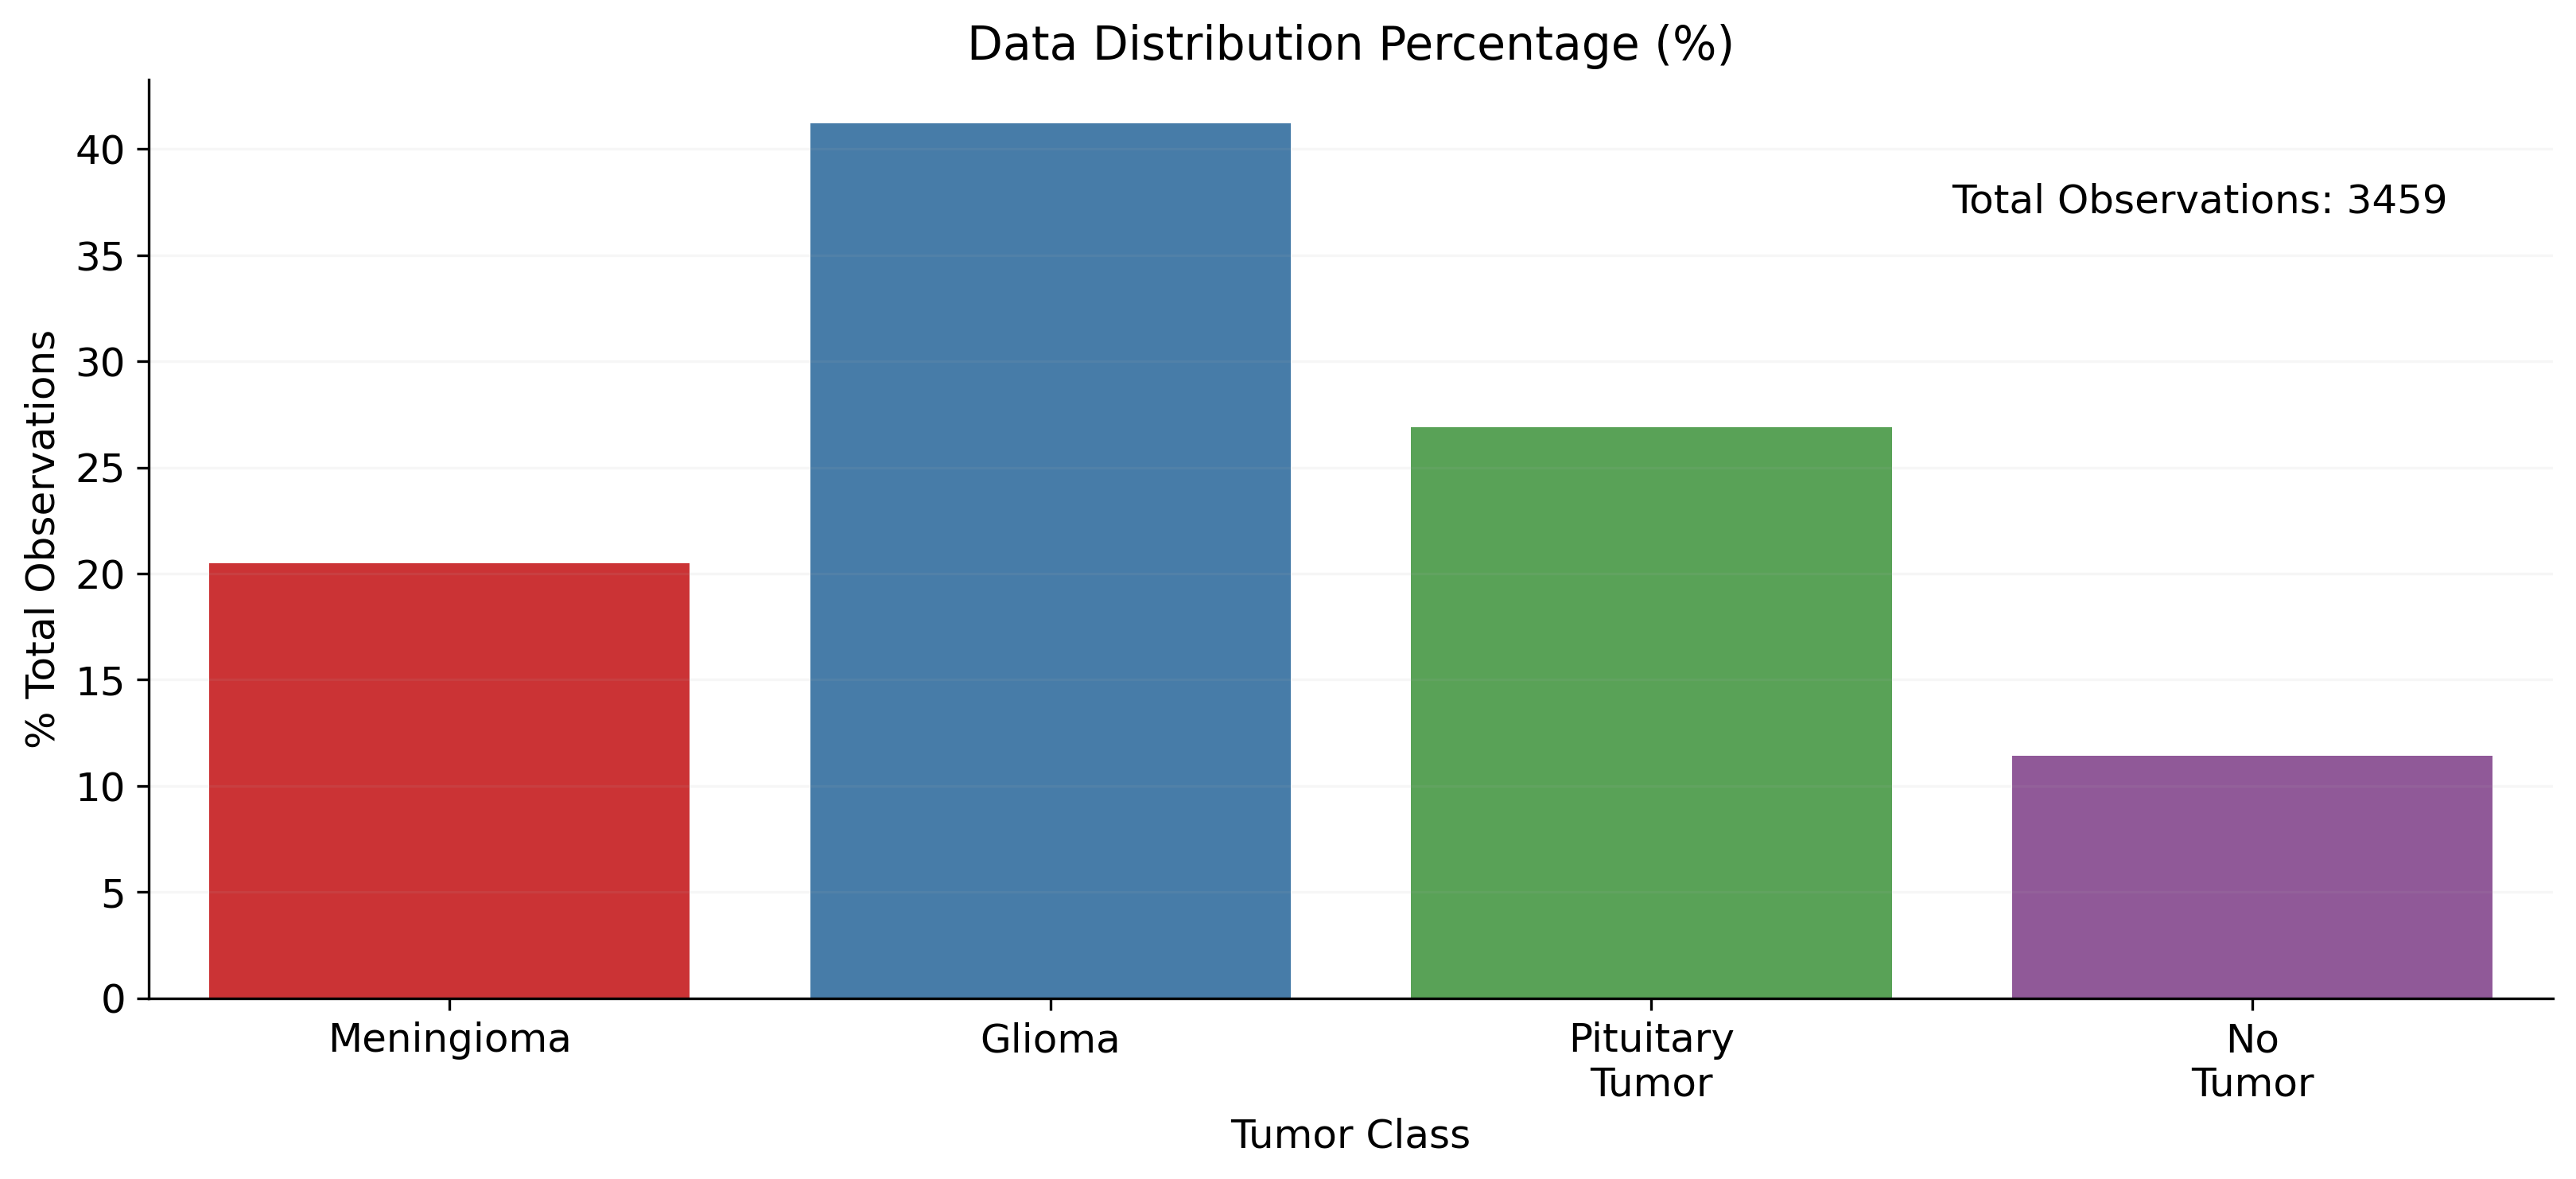

In [10]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y = 100 * (data_distribution_count / data_distribution_count.sum()),
            ax = axis,
            palette="Set1",
            hue=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index])
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

### **5.2 Visualisation of Brain MRI Dataset**

**Dataset Source: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427**  

**Source Code for Conversion of `.mat` file to `.jpg`: [Google Colab Notebook Link](https://colab.research.google.com/drive/1aucu3Ipj1eS0y1YEzKq76Z38TaetHSc3?usp=sharing)**  

**Final Dataset Link: https://drive.google.com/drive/folders/11QIC82FBdAyq0PUwLVNd22i-oq6lcat1?usp=sharing**

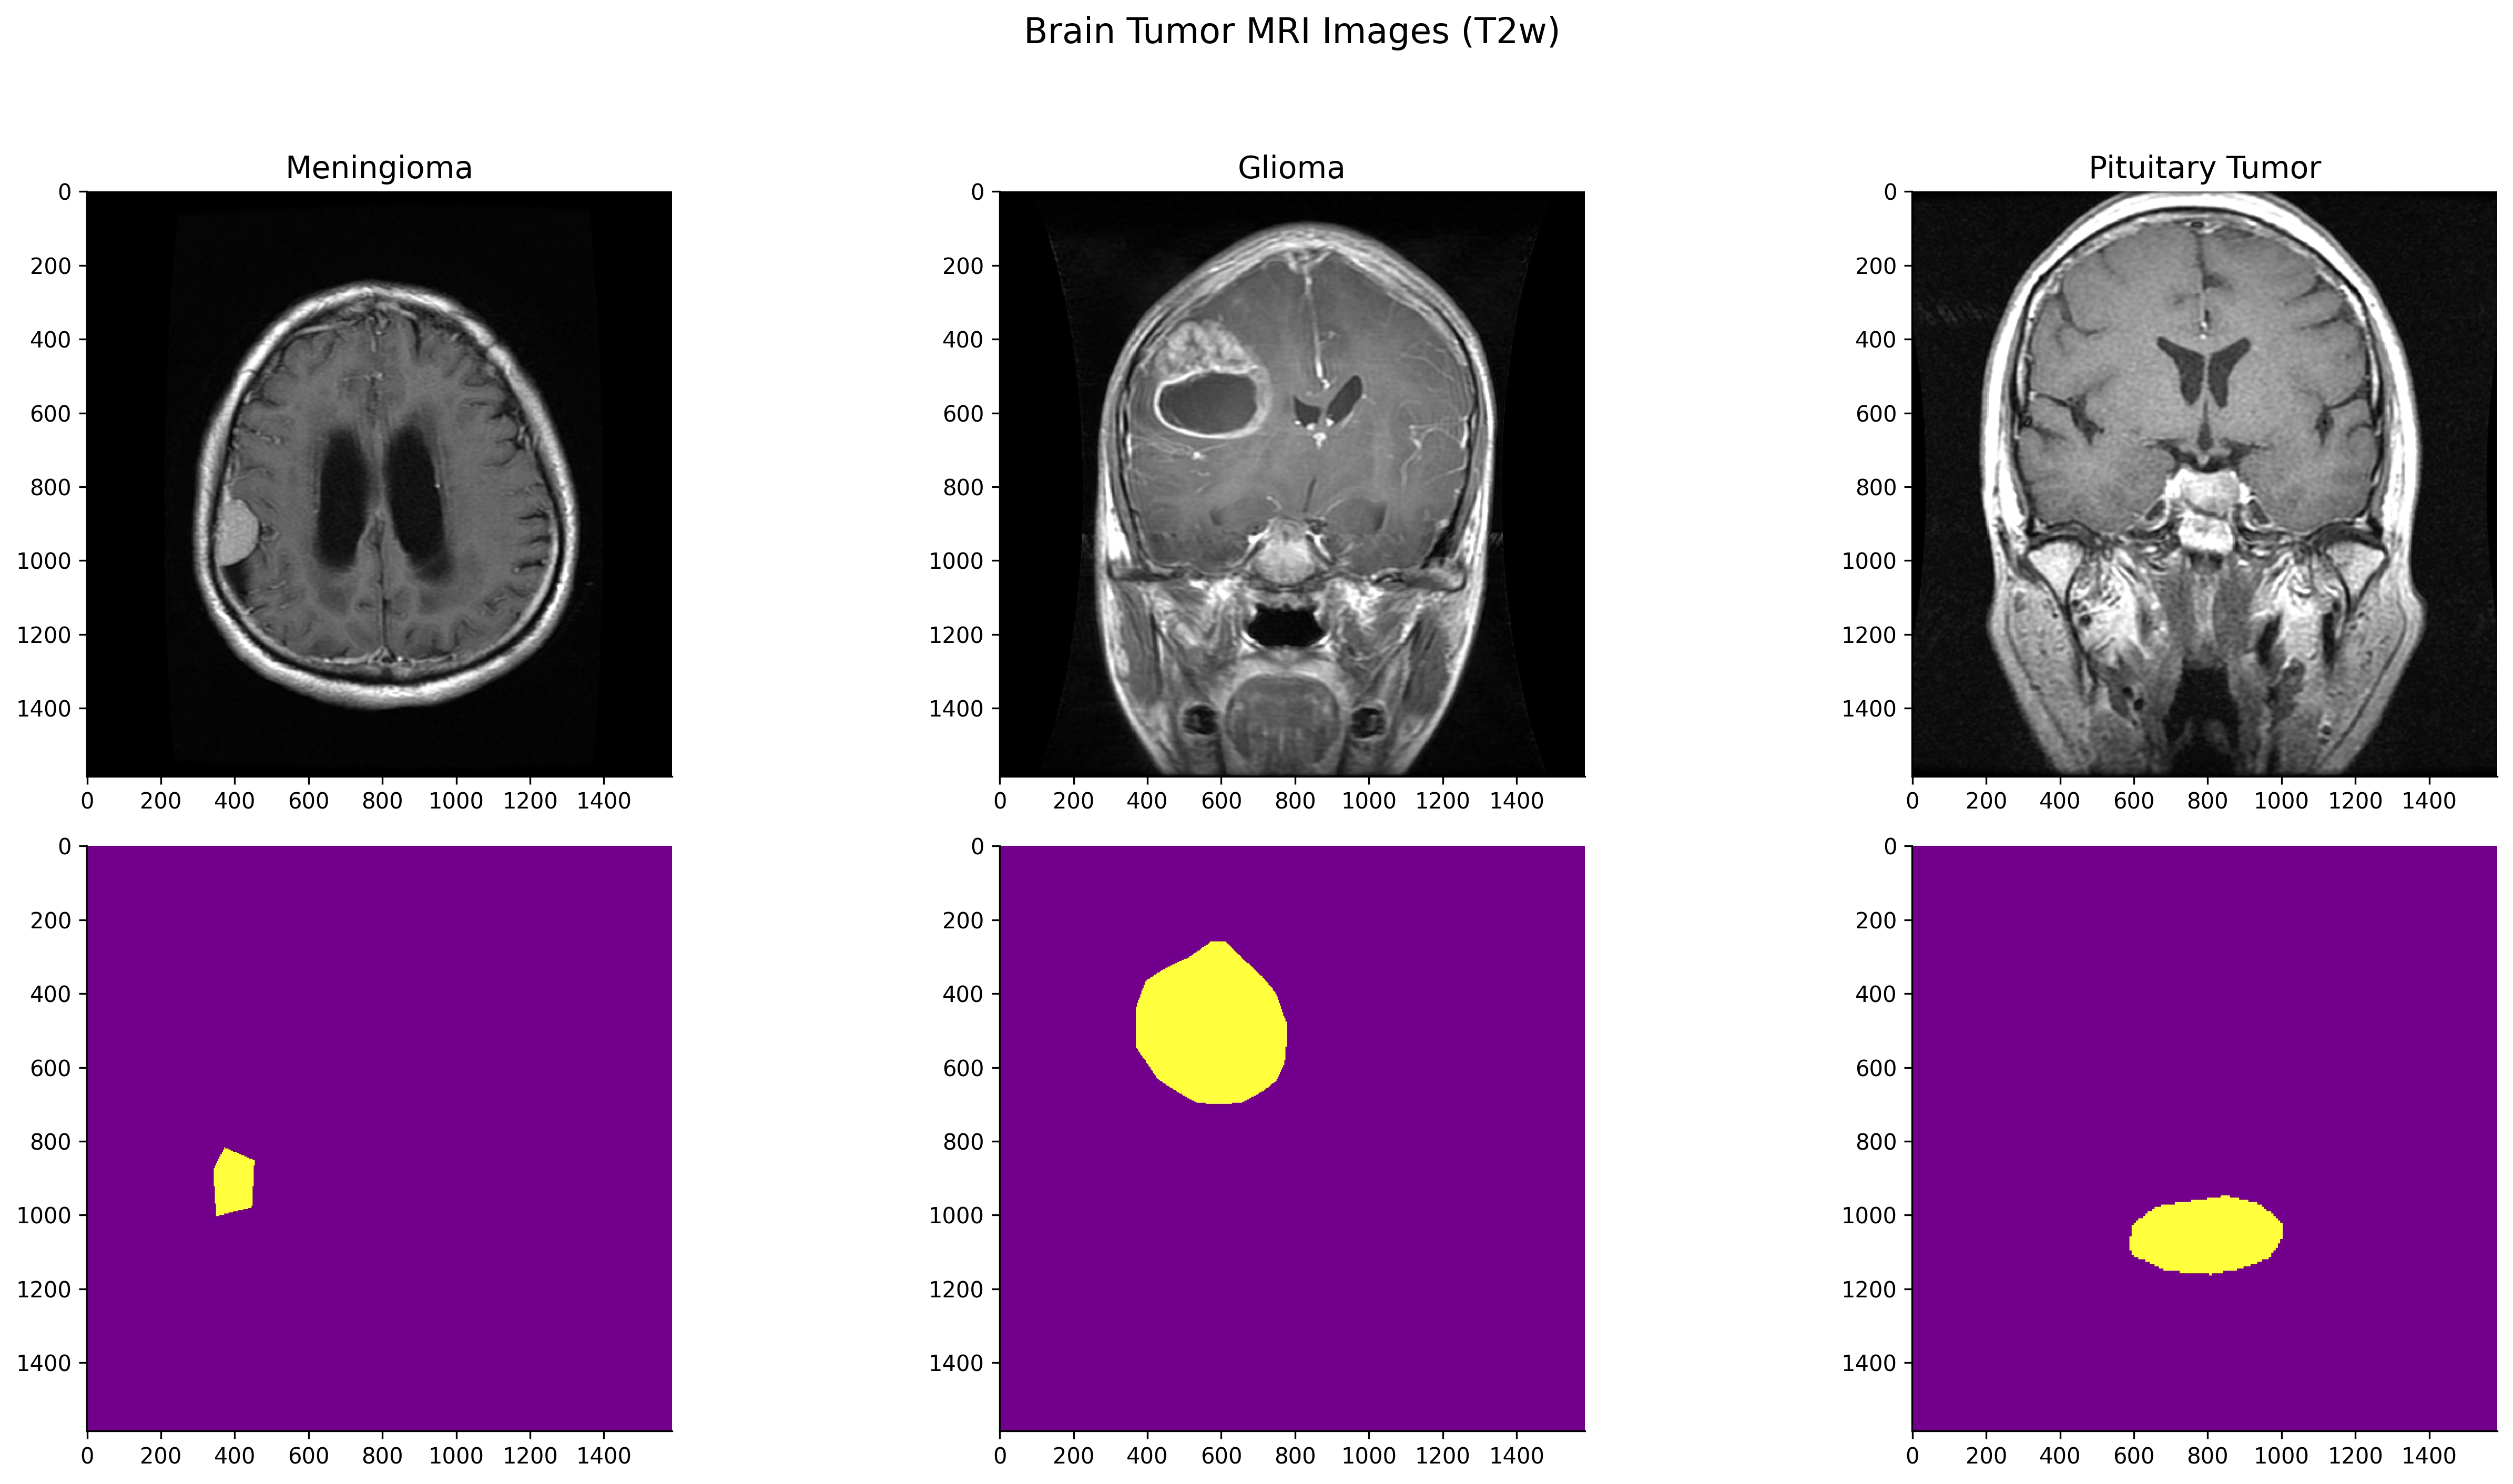

In [11]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS[:-1], IMAGE_DATA_PATHS[:-1], axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)

for filename, curr_axis in zip(MASK_DATA_PATHS, axes[3:]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    mask_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(mask_enhancer.enhance(BRIGHTNESS_FACTOR))
fig.tight_layout()
sns.despine()

### **6. Development of Training, Validation & Testing Dataset**

In [12]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [13]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

image_filepaths      tumor_class
0  /content/gdrive/MyDrive/Colab Notebooks/BrainT...       meningioma
1  /content/gdrive/MyDrive/Colab Notebooks/BrainT...       meningioma
2  /content/gdrive/MyDrive/Colab Notebooks/BrainT...  pituitary_tumor
3  /content/gdrive/MyDrive/Colab Notebooks/BrainT...  pituitary_tumor
4  /content/gdrive/MyDrive/Colab Notebooks/BrainT...  pituitary_tumor

In [14]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3459 non-null   object
 1   tumor_class      3459 non-null   object
dtypes: object(2)
memory usage: 54.2+ KB


In [15]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df,
                                                      train_size = 0.70,
                                                      random_state = 42,
                                                      stratify = image_data_paths_df.tumor_class)

train_data, validation_data = train_test_split(intermediate_train_data,
                                               train_size = 0.80,
                                               random_state = 42,
                                               stratify = intermediate_train_data.tumor_class)

### **6.1 Training, Validation and Testing Dataset Data Distribution Visualization**

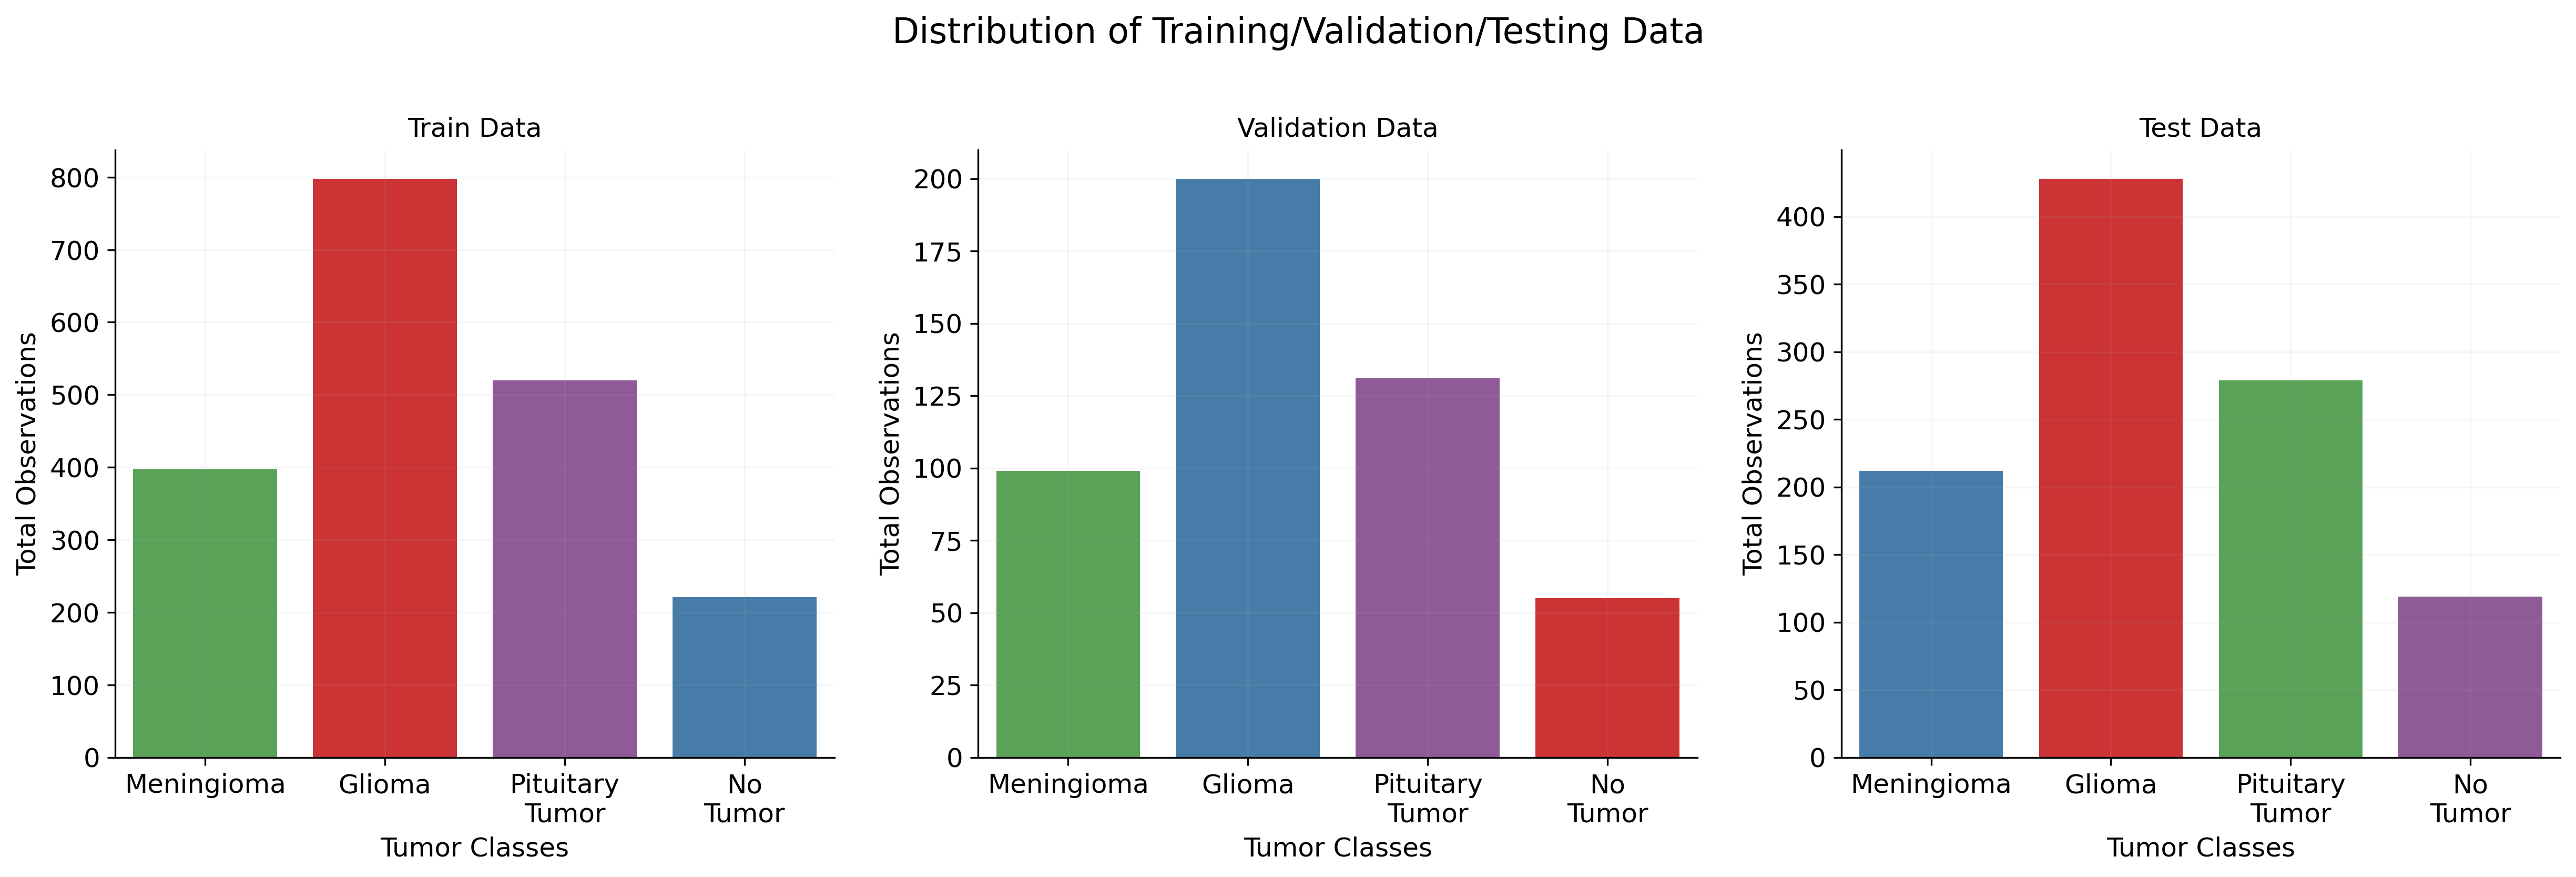

In [16]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASS, ax = axes[0], palette = "Set1", hue = train_data.tumor_class)
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASS, ax = axes[1], palette = "Set1", hue = validation_data.tumor_class)
sns.countplot(x = test_data.tumor_class, order = TUMOR_CLASS, ax = axes[2], palette = "Set1", hue = test_data.tumor_class)
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticks(range(len(TUMOR_CLASS)), TUMOR_CLASS, fontsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()

## **7. Data/Image Augmentation**
* Image augmentation is usually used to increase the image dataset and also to make the network more robust against translation invariance. Image augmentation is defined as creating duplicates of the original image datasets by flipping, rotating, zooming, and adjusting brightness.

* We will use data/image augmentation using `ImageDataGenerator` class to train the model on different types of combinations formed by rotation, flipping, changing the brightness etc of an image so as to increase our model accuracy.

In [17]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15,
                            width_shift_range = 0.1,
                            zoom_range = 0.01,
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [18]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [19]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data,
                                                                  x_col = 'image_filepaths',
                                                                  y_col = 'tumor_class',
                                                                  seed = 42,
                                                                  batch_size = batch_size,
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1936 validated image filenames belonging to 4 classes.
Found 485 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.


In [20]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')

print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')

print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)


### **7.1 Training Data Images Glimpse**

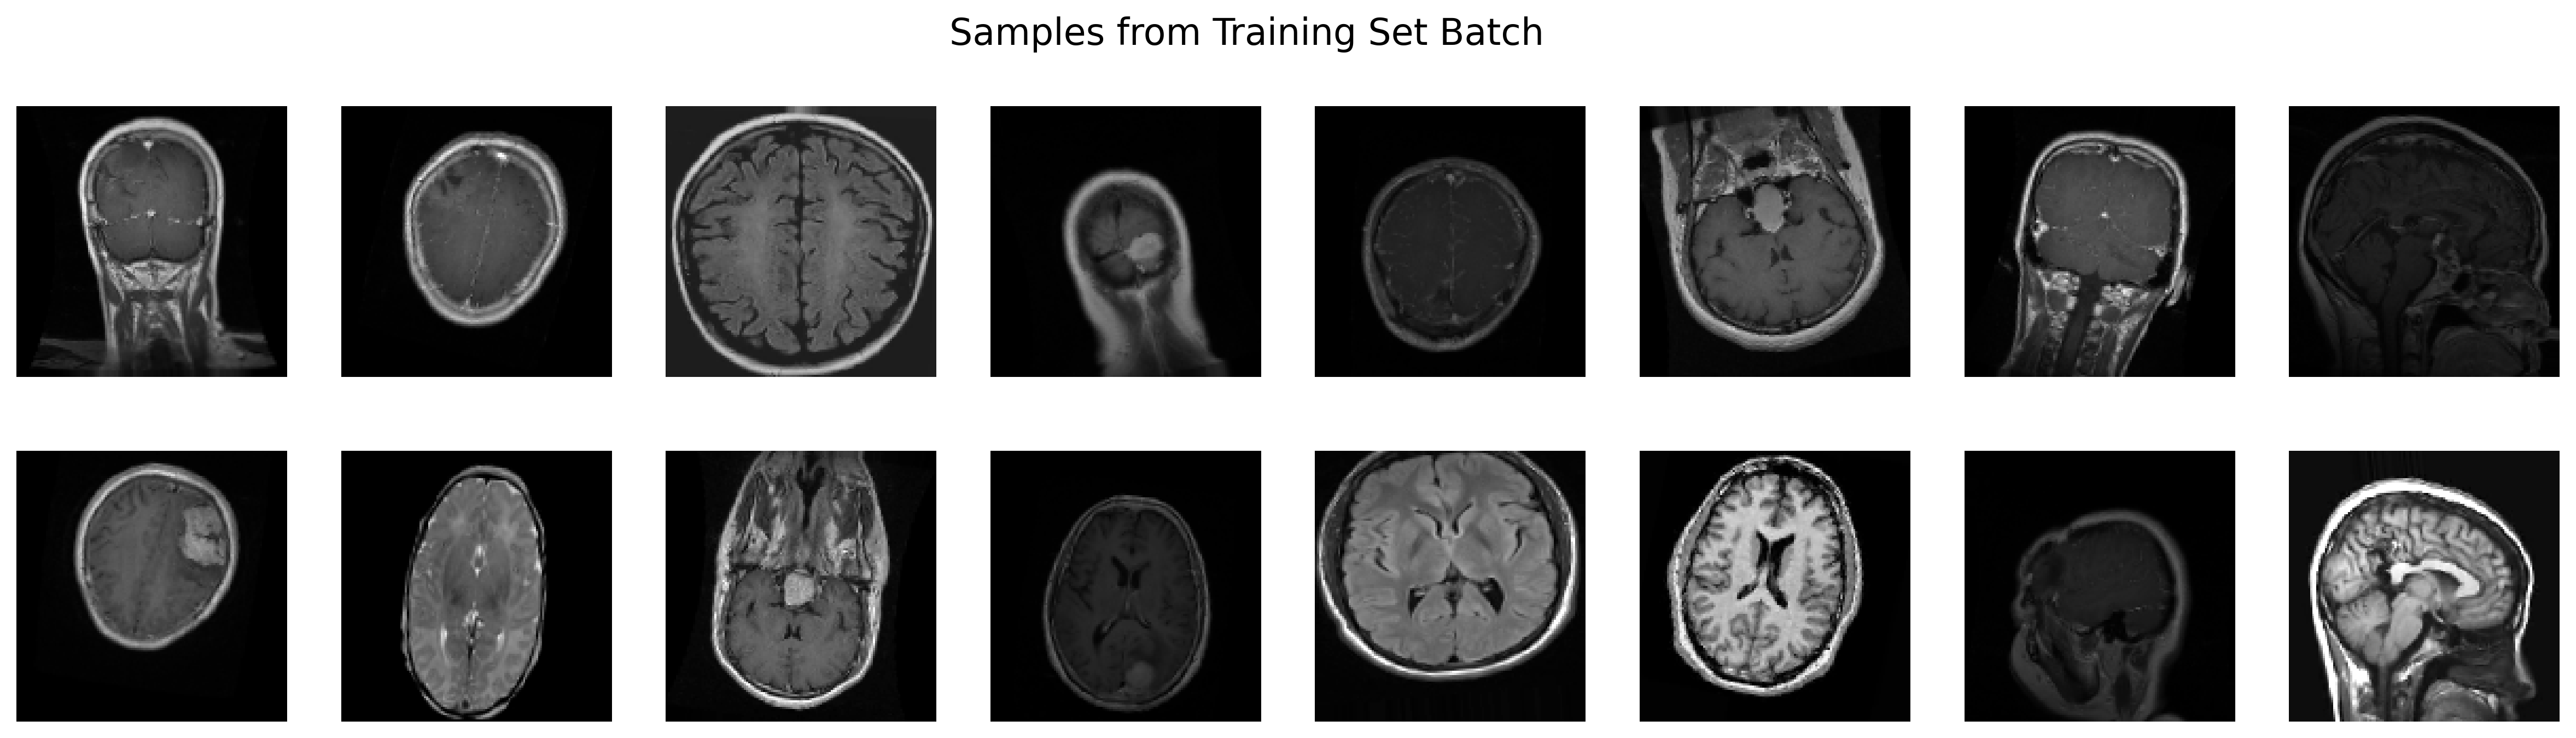

In [21]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

### **7.2 Validation Data Images Glimpse**

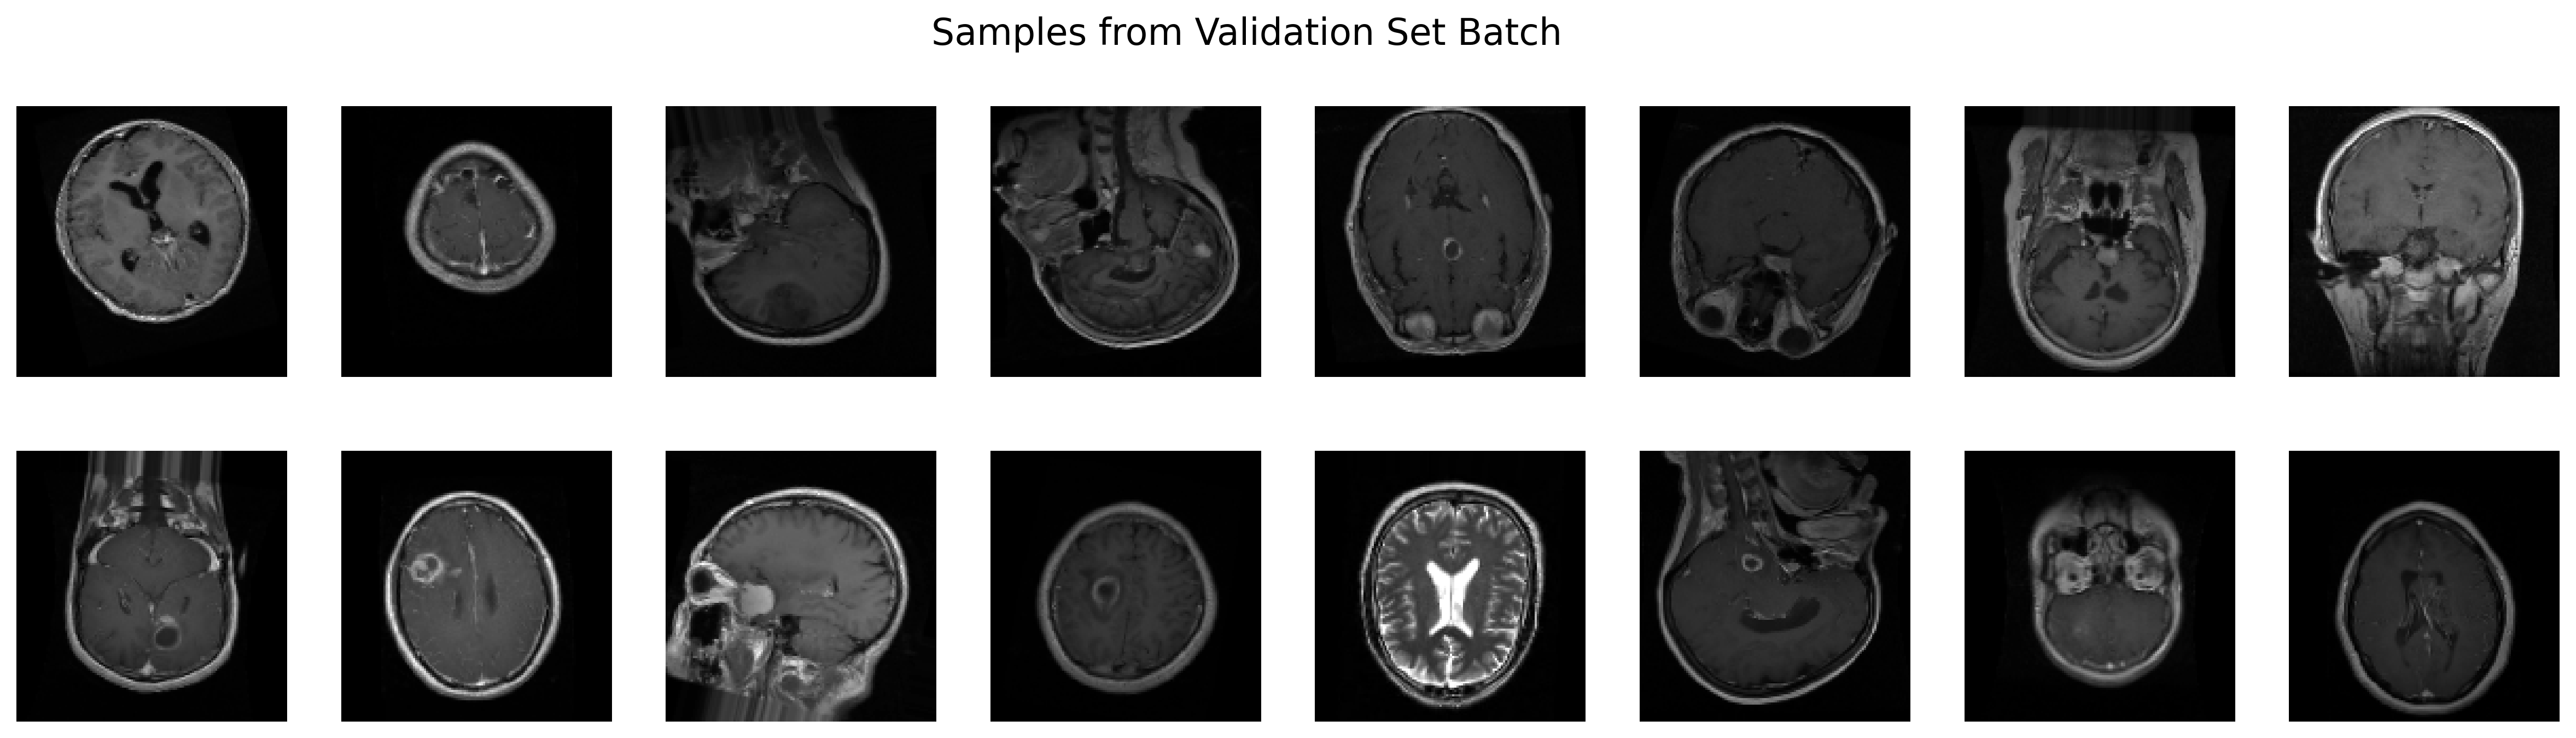

In [22]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

### **7.3 Testing Data Images Glimpse**

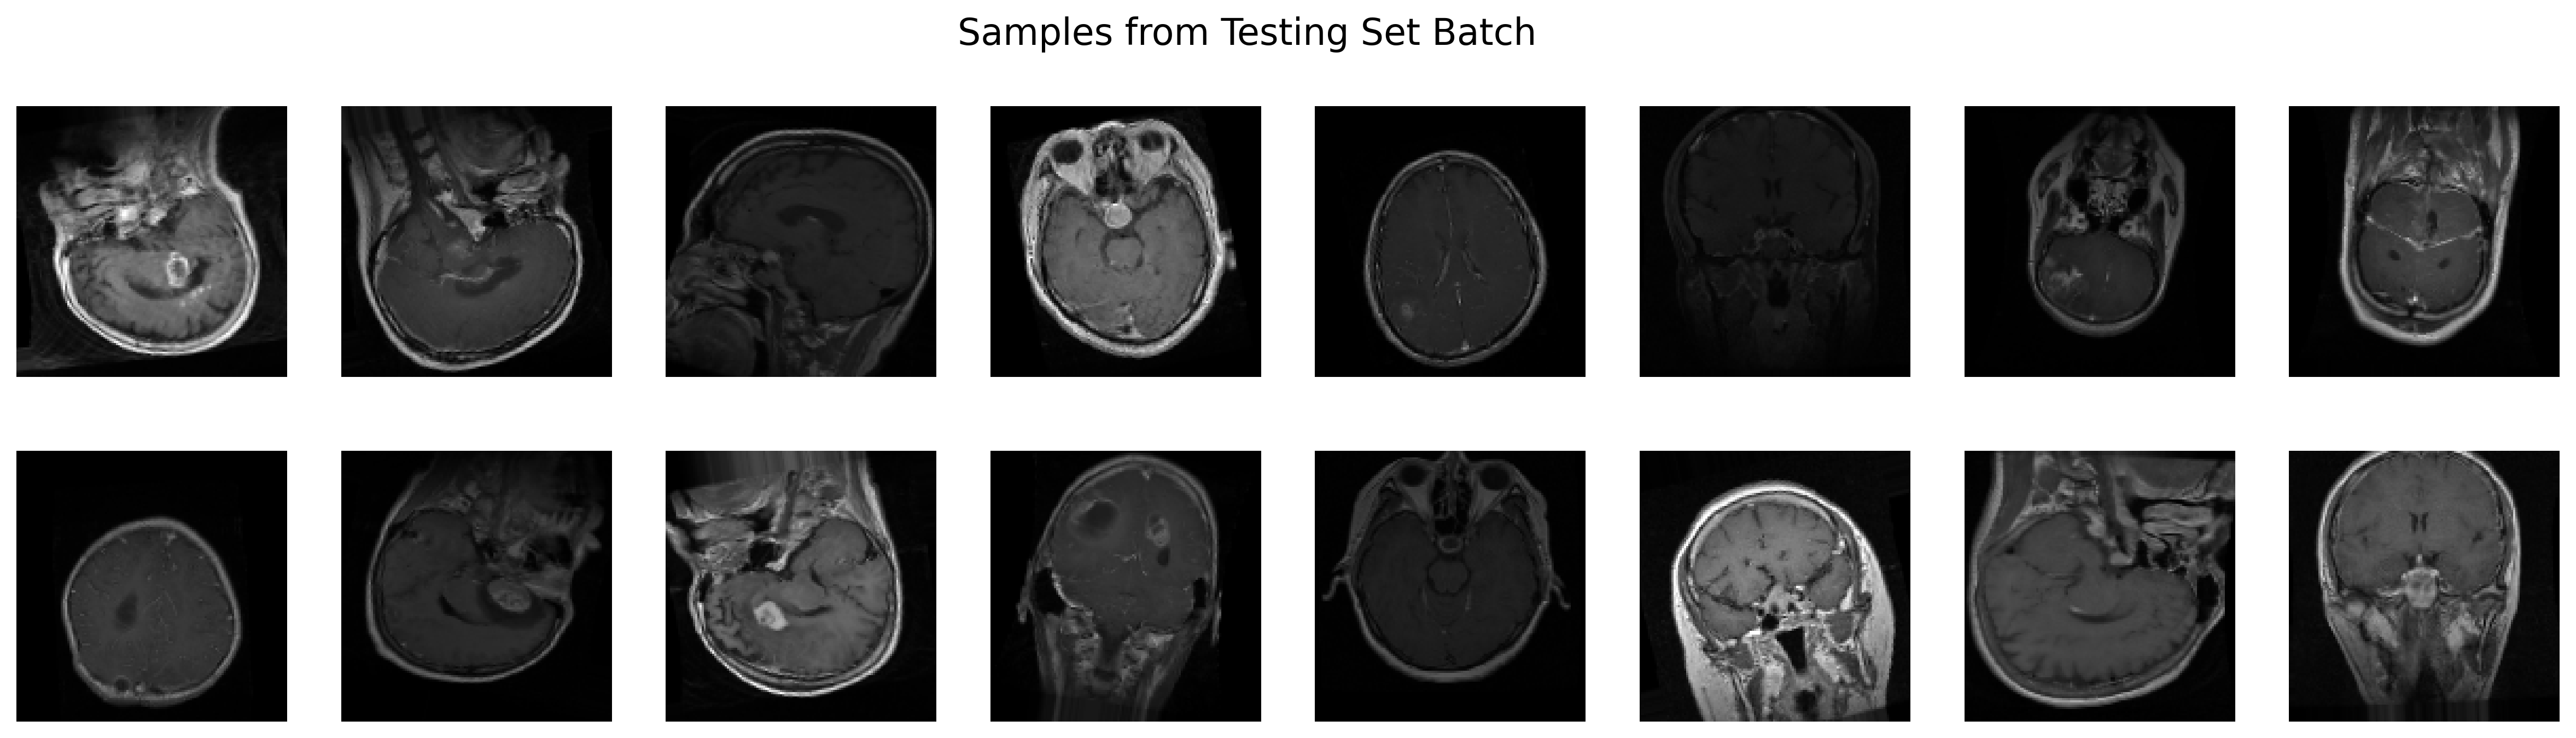

In [23]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

## **8. Model Development**

In [24]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [25]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")

os.makedirs(ROOT_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(MLP_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(ALEXNET_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(INCEPTIONV3_CHECKPOINT_DIR_PATH, exist_ok=True)

assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

In [26]:
mlp_cp_callback = ModelCheckpoint(
    os.path.join(MLP_CHECKPOINT_DIR_PATH, "mlp_checkpoint.weights.h5"),
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

alexnet_cp_callback = ModelCheckpoint(
    os.path.join(ALEXNET_CHECKPOINT_DIR_PATH, "alexnet_checkpoint.weights.h5"),
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

inceptionv3_cp_callback = ModelCheckpoint(
    os.path.join(INCEPTIONV3_CHECKPOINT_DIR_PATH, "inceptionv3_checkpoint.weights.h5"),
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

In [27]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [28]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']

    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)

    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [29]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models) > 0, "At least one model must be provided."
    report_columns = [
        'Macro Precision', 'Micro Precision', 'Weighted Precision',
        'Macro Recall', 'Micro Recall', 'Weighted Recall',
        'Macro F1-Score', 'Micro F1-Score', 'Weighted F1-Score',
        'Cohen\'s Kappa', 'Log Loss'
    ]
    report_df = pd.DataFrame(columns=report_columns)
    y = test_dataset.classes

    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential), "Each model must be a Sequential model."

        # Model predictions
        y_preds_prob = curr_model.predict(test_dataset)
        y_preds = np.argmax(y_preds_prob, axis=1)

        # Metric calculations
        macro_precision = precision_score(y, y_preds, average='macro')
        micro_precision = precision_score(y, y_preds, average='micro')
        weighted_precision = precision_score(y, y_preds, average='weighted')

        macro_recall = recall_score(y, y_preds, average='macro')
        micro_recall = recall_score(y, y_preds, average='micro')
        weighted_recall = recall_score(y, y_preds, average='weighted')

        macro_f1 = f1_score(y, y_preds, average='macro')
        micro_f1 = f1_score(y, y_preds, average='micro')
        weighted_f1 = f1_score(y, y_preds, average='weighted')

        cohens_kappa = cohen_kappa_score(y, y_preds)
        log_loss_value = log_loss(y, y_preds_prob)

        # Store results in DataFrame
        report_df.loc[curr_index] = [
            macro_precision, micro_precision, weighted_precision,
            macro_recall, micro_recall, weighted_recall,
            macro_f1, micro_f1, weighted_f1,
            cohens_kappa, log_loss_value
        ]

    report_df.index = row_indexes
    return report_df

In [30]:
def save_model_weights(model, save_dir, filename="model.weights.h5"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_path = os.path.join(save_dir, filename)

    # Check if weights file already exists
    if os.path.exists(file_path):
        print(f"Weights already exist at {file_path}. Skipping save.")
    else:
        model.save_weights(file_path)
        print(f"Model weights saved to {file_path}")

### **8.1 Multi-Layer Perceptron**

#### **8.1.1 Development of Multi-Layer Perceptron Model**

In [31]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten-Layer (Flatten)     (None, 49152)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 2048)              100665344 
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 2048)              0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 1024)              2098176   
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 1024)              0         
                                                                 
 Hidden-Layer-3 (Dense)      (None, 512)               524800    
                                                                 
 Dropout-Layer-3 (Dropout)   (None, 512)               0

#### **8.1.2 Training and Validation of Multi-Layer Perceptron Based Model**

In [ ]:
mlp_train_history = mlp_model.fit(train_dataset,
                                  batch_size = batch_size,
                                  validation_data = validation_dataset,
                                  epochs = 100,
                                  callbacks = [early_stopping])

Epoch 1/100
61/61 [==============================] - 619s 10s/step - loss: 4.1441 - accuracy: 0.3993 - val_loss: 1.2673 - val_accuracy: 0.5546
Epoch 2/100
61/61 [==============================] - 54s 887ms/step - loss: 1.2320 - accuracy: 0.4985 - val_loss: 1.1727 - val_accuracy: 0.5732
Epoch 3/100
61/61 [==============================] - 53s 875ms/step - loss: 1.1851 - accuracy: 0.5145 - val_loss: 1.1333 - val_accuracy: 0.5691
Epoch 4/100
61/61 [==============================] - 54s 886ms/step - loss: 1.1474 - accuracy: 0.5532 - val_loss: 1.1337 - val_accuracy: 0.5649
Epoch 5/100
61/61 [==============================] - 53s 867ms/step - loss: 1.1317 - accuracy: 0.5558 - val_loss: 1.1164 - val_accuracy: 0.5814
Epoch 6/100
61/61 [==============================] - 54s 878ms/step - loss: 1.0991 - accuracy: 0.5671 - val_loss: 1.0886 - val_accuracy: 0.5711
Epoch 7/100
61/61 [==============================] - 53s 870ms/step - loss: 1.0732 - accuracy: 0.5935 - val_loss: 1.0740 - val_accuracy: 

#### **8.1.3 Multi-Layer Perceptron Based Model Training Process Statistics**

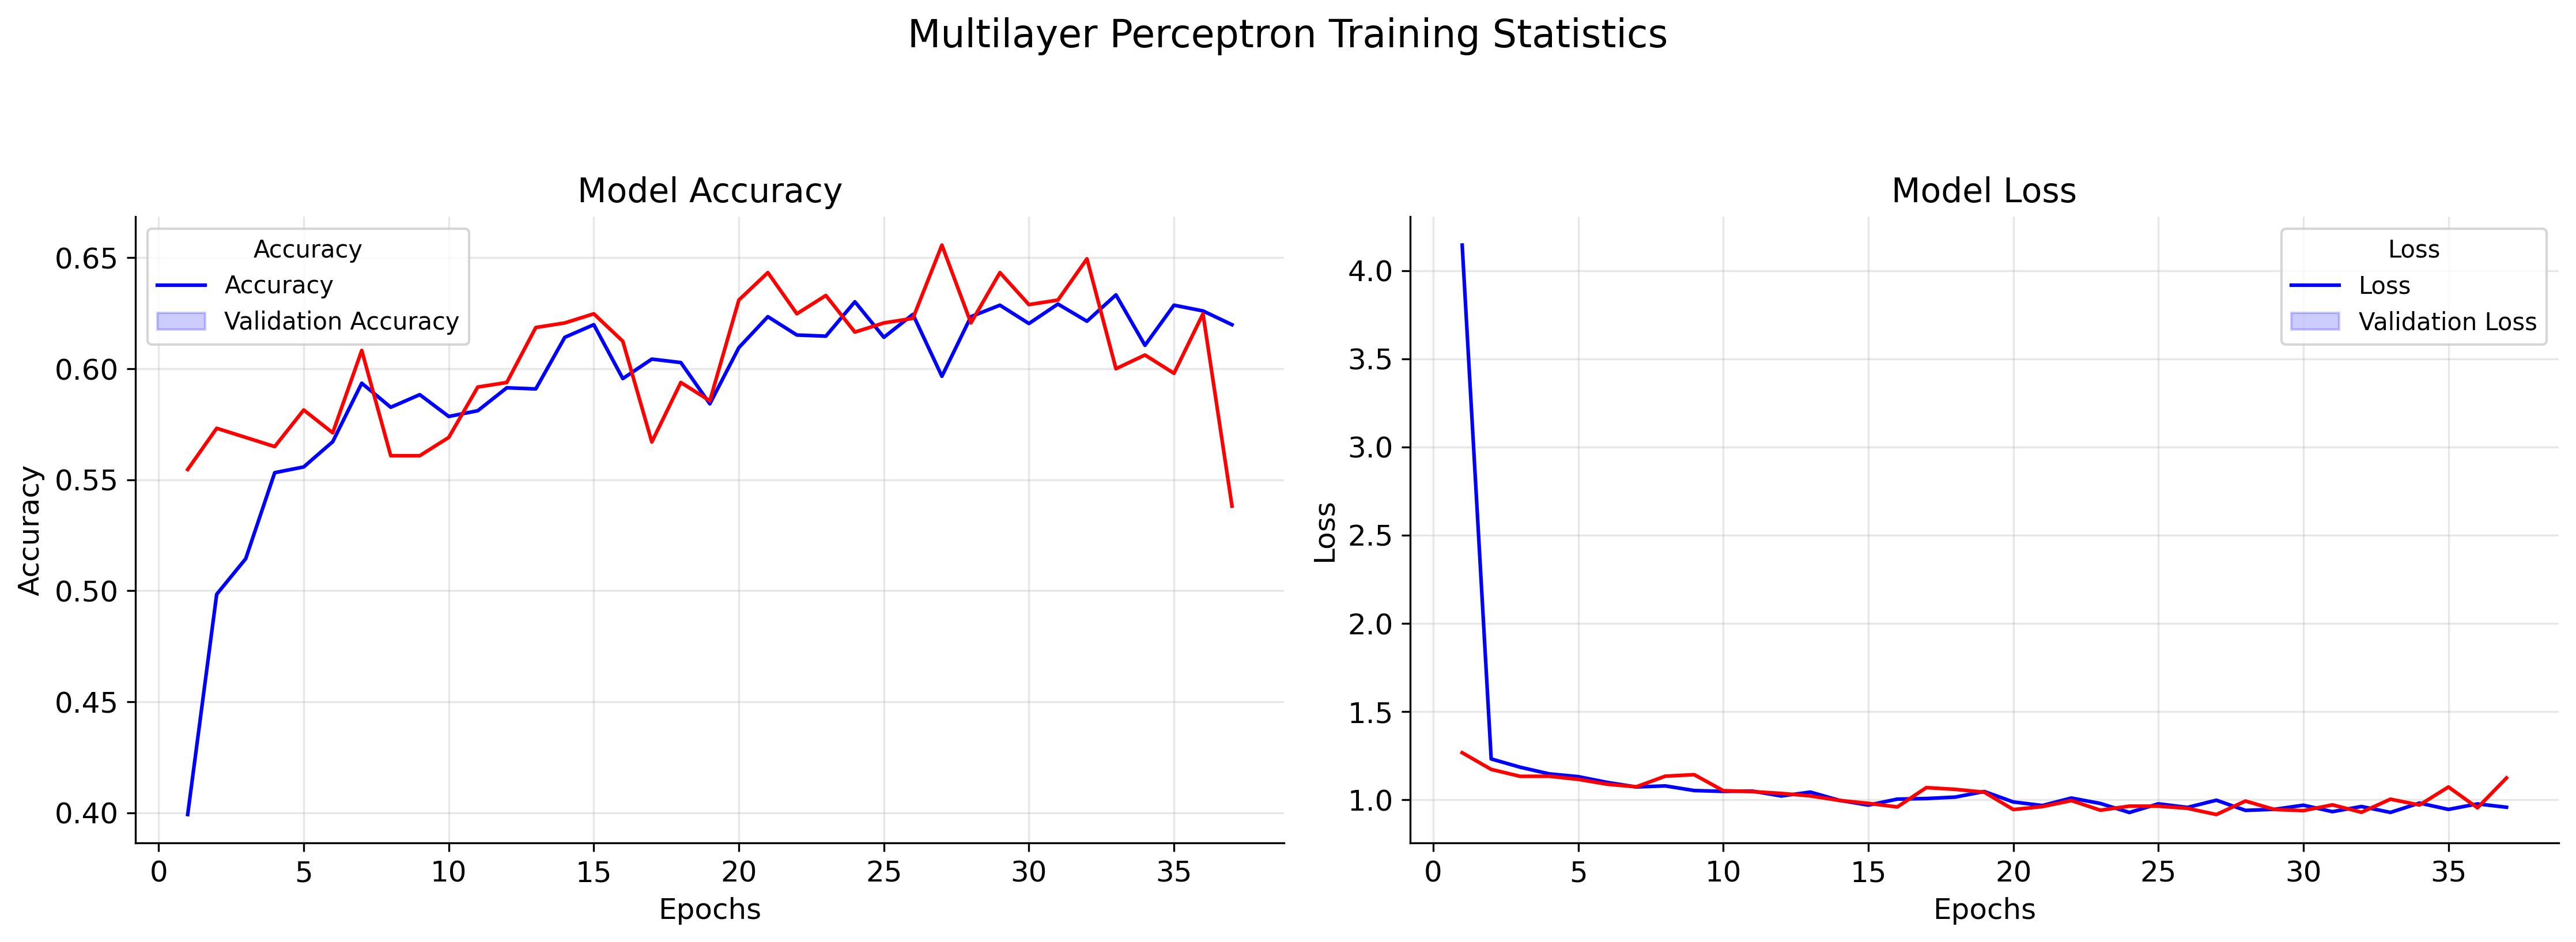

In [ ]:
training_process_viz(pd.DataFrame(mlp_train_history.history),
                     plot_title = 'Multilayer Perceptron Training Statistics')

#### **8.1.4 Confusion Matrix for Multi-Layer Perceptron Based Model**

61/61 [==============================] - 34s 553ms/step


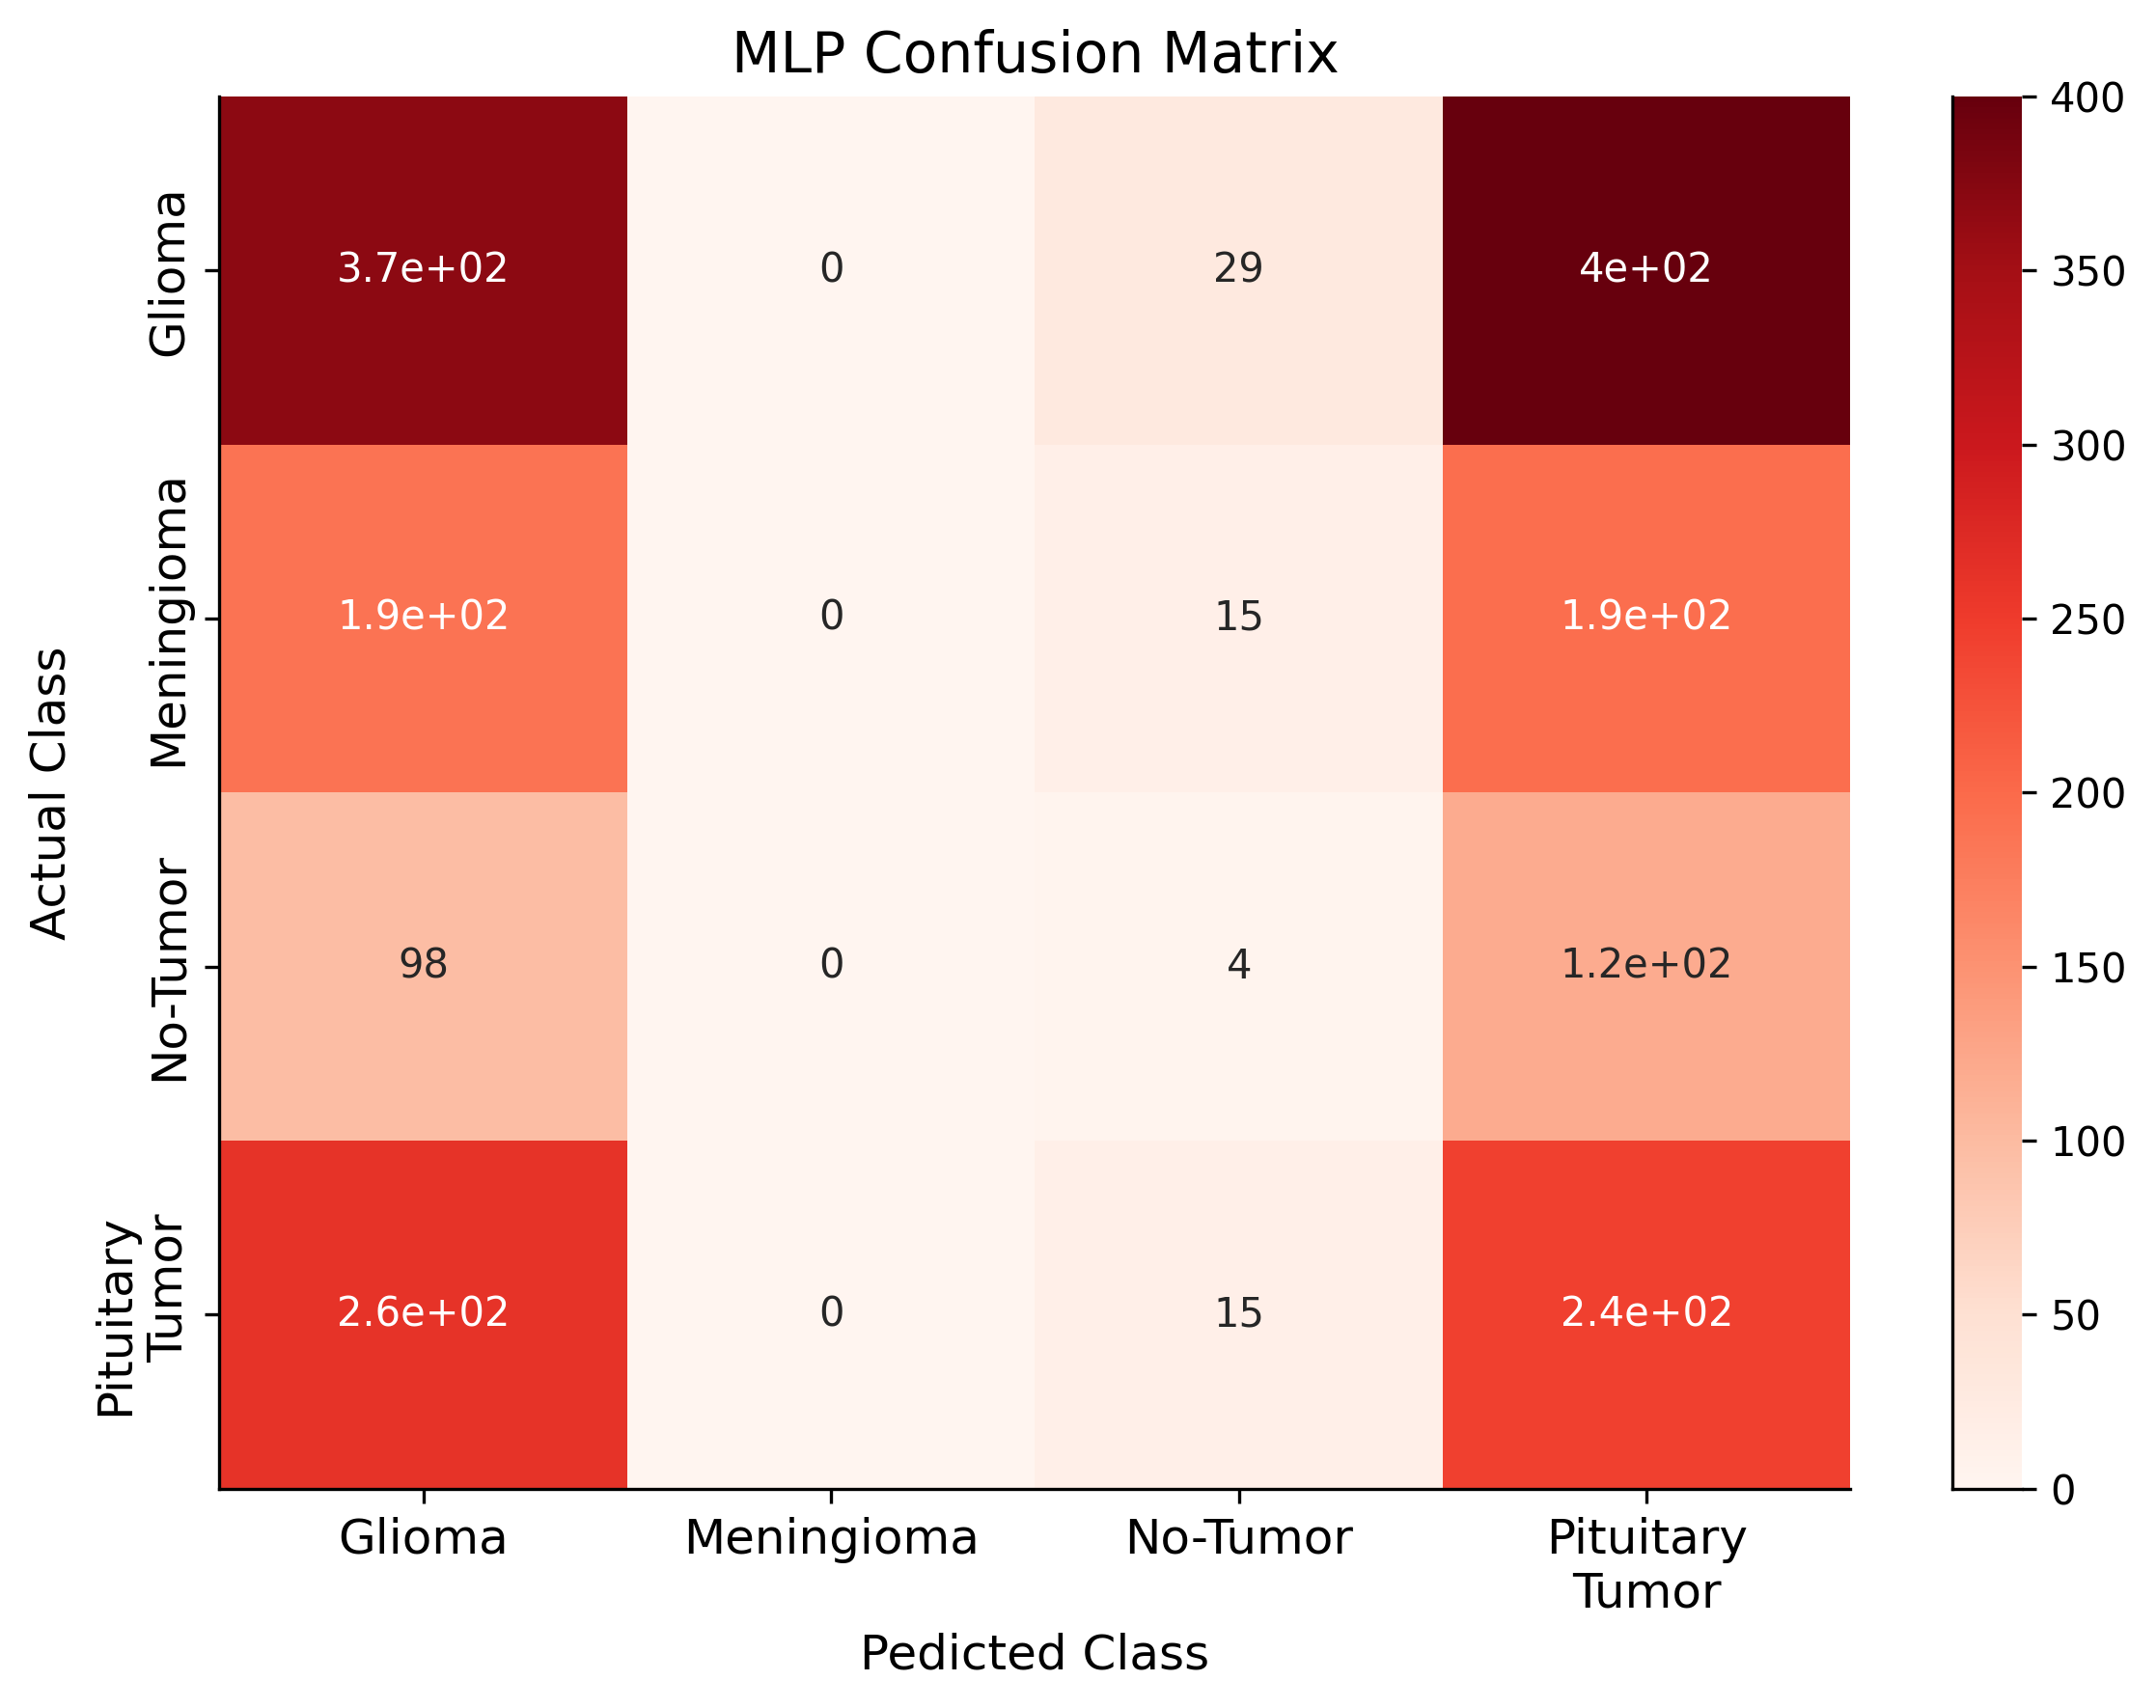

In [ ]:
confusion_matrix_viz(mlp_model, train_dataset, plot_title = "MLP Confusion Matrix")

In [34]:
file_path = os.path.join(MLP_CHECKPOINT_DIR_PATH, "model.weights.h5")
mlp_model.load_weights(file_path)

In [35]:
mlp_report_df = generate_report(mlp_model,
                                test_dataset = test_dataset,
                                row_indexes = ("Multi-Layer-Perceptron Model",))
display(mlp_report_df)

33/33 [==============================] - 234s 7s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro Precision  Micro Precision  \
Multi-Layer-Perceptron Model         0.193459         0.319846   

                              Weighted Precision  Macro Recall  Micro Recall  \
Multi-Layer-Perceptron Model            0.245528      0.235597      0.319846   

                              Weighted Recall  Macro F1-Score  Micro F1-Score  \
Multi-Layer-Perceptron Model         0.319846        0.198146        0.319846   

                              Weighted F1-Score  Cohen's Kappa  Log Loss  
Multi-Layer-Perceptron Model           0.269918      -0.026952  1.977685

In [ ]:
save_model_weights(mlp_model, MLP_CHECKPOINT_DIR_PATH)

Weights already exist at /content/gdrive/MyDrive/Colab Notebooks/BrainTumorDataset/Model-Checkpoints/Multi-Layer-Perceptron/model_weights.h5. Skipping save.


### **8.2 AlexNet CNN**

#### **8.2.1 Develoment of AlexNet CNN Model**

In [36]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 Batch-Normalization-1 (Bat  (None, 30, 30, 96)        384       
 chNormalization)                                                
                                                                 
 Max-Pooling-1 (MaxPooling2  (None, 14, 14, 96)        0         
 D)                                                              
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 Batch-Normalization-2 (Bat  (None, 14, 14, 256)       1024      
 chNormalization)                                                
                                                      

#### **8.2.2 Training and Validation of AlexNet CNN Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    alexnet_train_history = alexnet_cnn.fit(train_dataset,
                                            batch_size = batch_size,
                                            validation_data = validation_dataset,
                                            epochs = 100,
                                            callbacks = [early_stopping, alexnet_cp_callback])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3266 - loss: 2.6377 
Epoch 1: saving model to /content/gdrive/MyDrive/Colab Notebooks/BrainTumorDataset/Model-Checkpoints/AlexNet-CNN/alexnet_checkpoint.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 912s 13s/step - accuracy: 0.3270 - loss: 2.6271 - val_accuracy: 0.4021 - val_loss: 1.5075
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4272 - loss: 1.2915
Epoch 2: saving model to /content/gdrive/MyDrive/Colab Notebooks/BrainTumorDataset/Model-Checkpoints/AlexNet-CNN/alexnet_checkpoint.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.4273 - loss: 1.2914 - val_accuracy: 0.3567 - val_loss: 1.5751
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4342 - loss: 1.2836
Epoch 3: saving model to /content/gdrive/MyDrive/Colab Notebooks/BrainTumorDataset/Model-Checkpoints/AlexNet-CNN/alexnet_checkpoint.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.4344 - loss: 1.2832 - val_accuracy: 0.3608

#### **8.2.3 AlexNet CNN Model Training Process Statistics**

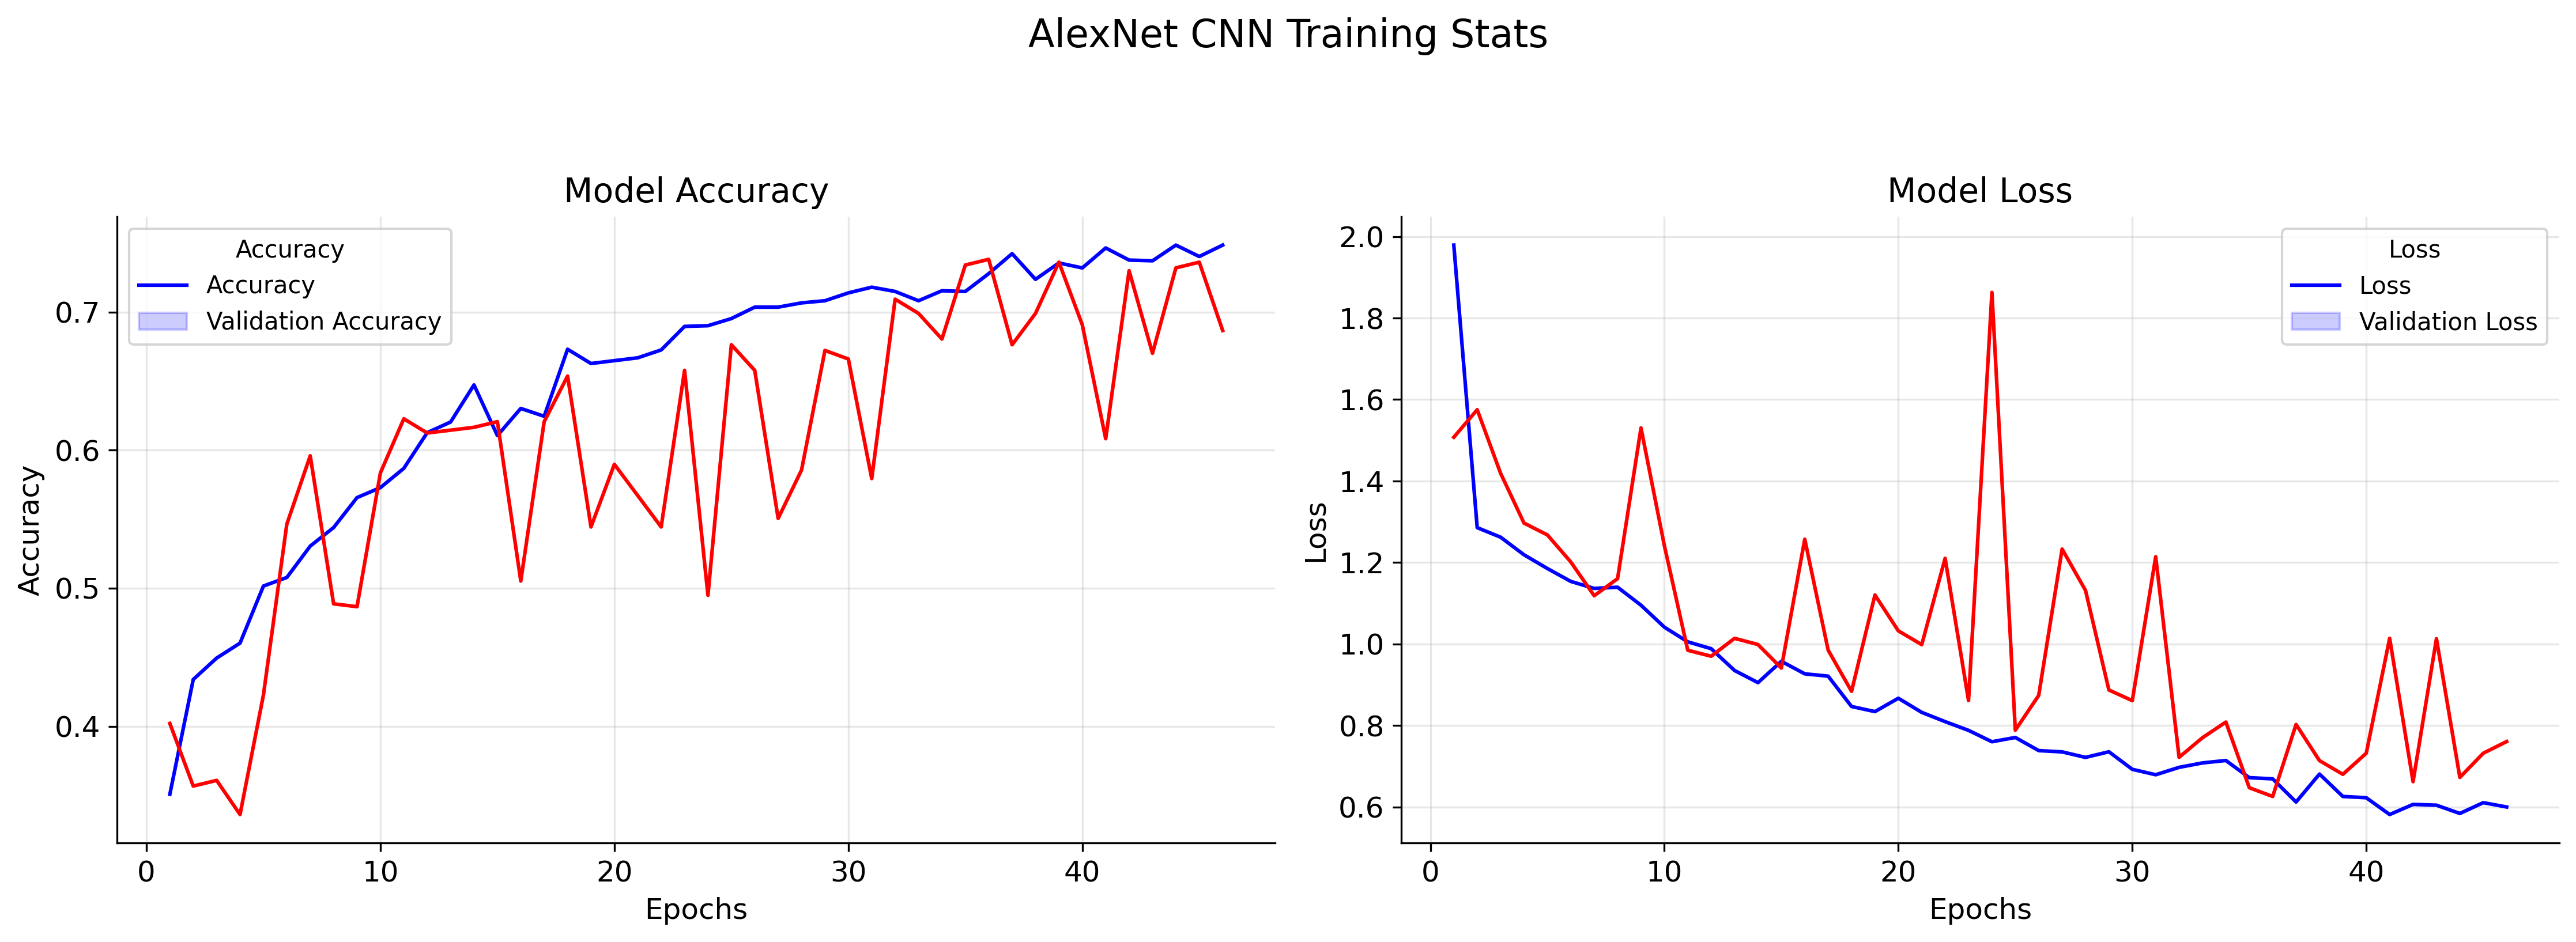

In [ ]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

#### **8.2.4 Confusion Matrix for AlexNet CNN Model**

33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


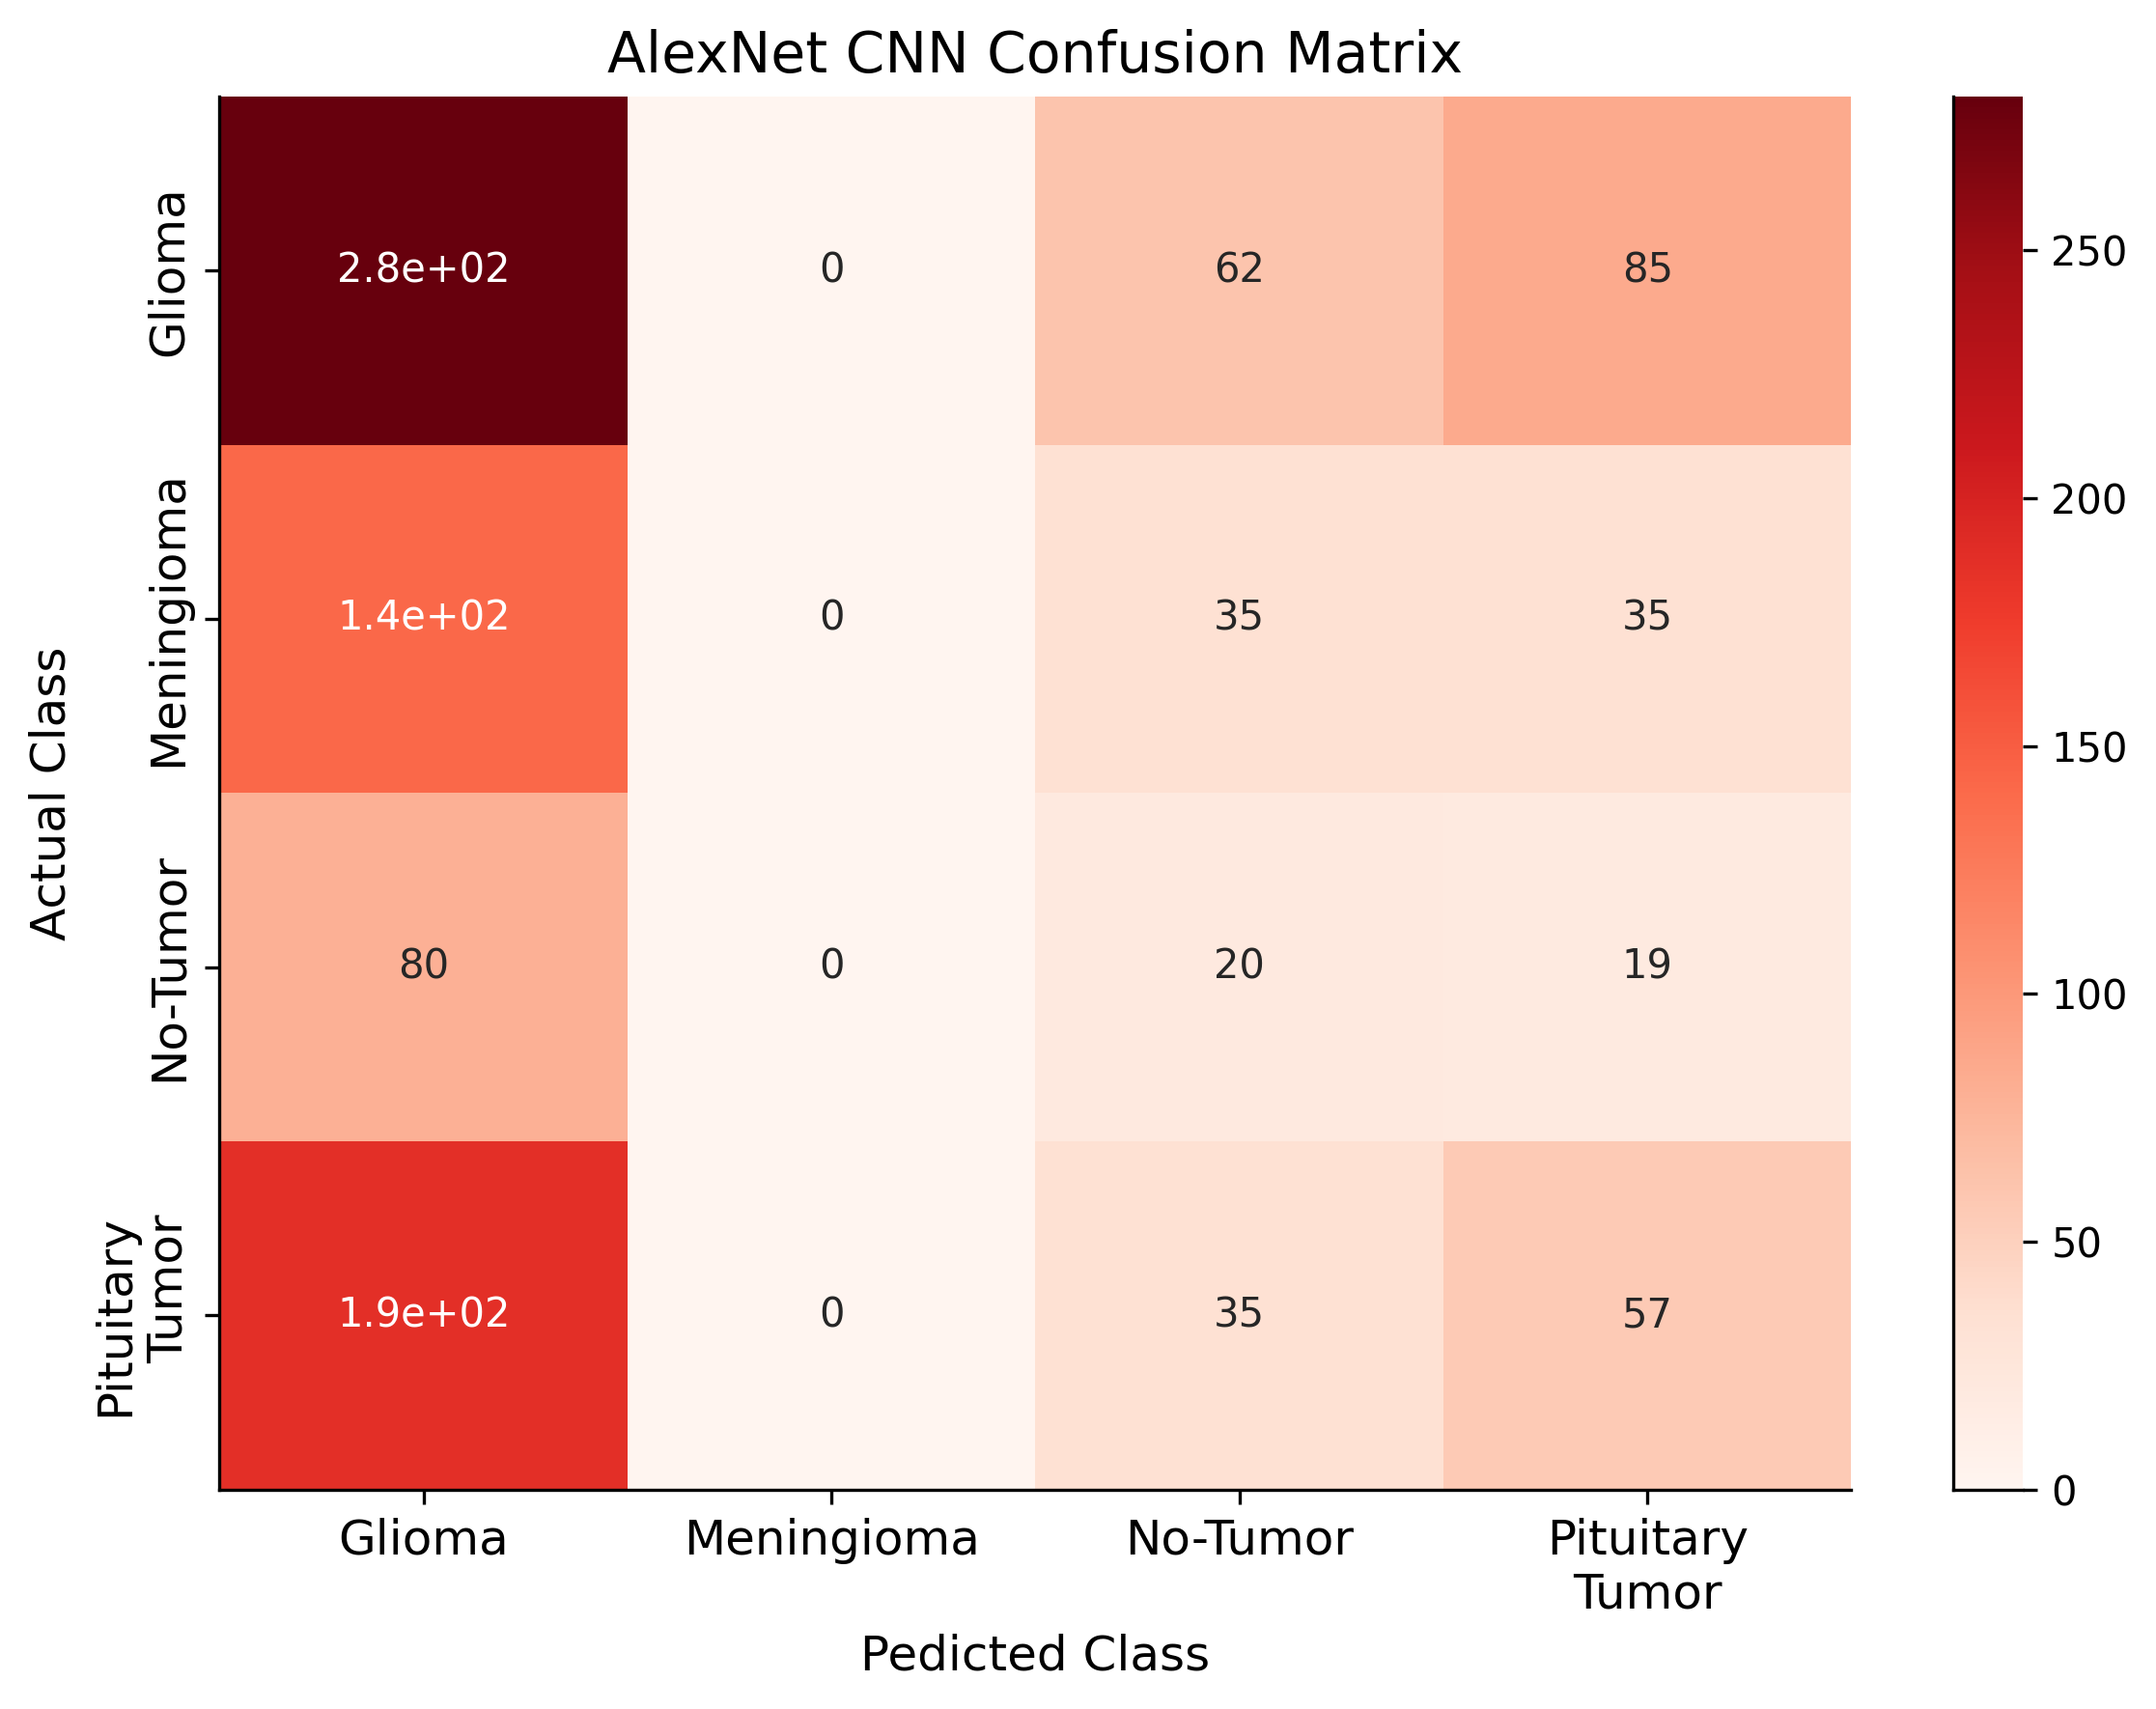

In [ ]:
confusion_matrix_viz(alexnet_cnn,
                         test_dataset,
                         plot_title = "AlexNet CNN Confusion Matrix")

In [37]:
file_path = os.path.join(ALEXNET_CHECKPOINT_DIR_PATH, "model.weights.h5")
alexnet_cnn.load_weights(file_path)

In [38]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = test_dataset, row_indexes = ['AlexNet CNN'])
display(alexnet_report_df)

33/33 [==============================] - 18s 545ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro Precision  Micro Precision  Weighted Precision  \
AlexNet CNN         0.186801         0.333333            0.245808   

             Macro Recall  Micro Recall  Weighted Recall  Macro F1-Score  \
AlexNet CNN      0.236837      0.333333         0.333333        0.203208   

             Micro F1-Score  Weighted F1-Score  Cohen's Kappa  Log Loss  
AlexNet CNN        0.333333           0.276177      -0.016031  3.700117

In [ ]:
save_model_weights(alexnet_cnn, ALEXNET_CHECKPOINT_DIR_PATH)

Model weights saved to /content/gdrive/MyDrive/Colab Notebooks/BrainTumorDataset/Model-Checkpoints/AlexNet-CNN/model.weights.h5


### **8.3 Inception V3**

#### **8.3.1 Developement of InceptionV3**

In [39]:
inception_v3_model = InceptionV3(include_top = False,
                                 input_shape = (image_size, image_size, 3),
                                 pooling = 'avg')
inception_v3_model.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [40]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 1024)              2098176   
                                                                 
 Output-Layer (Dense)        (None, 4)                 4100      
                                                                 
Total params: 23905060 (91.19 MB)
Trainable params: 2102276 (8.02 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


#### **8.3.2 Training and Validation of InceptionV3 Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    inception_model_train_history = inception_cnn_model.fit(train_dataset,
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset,
                                                            epochs = 100,
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])

#### **8.3.3 InceptionV3 Model Training Process Statistics**

In [ ]:
training_process_viz(pd.DataFrame(inception_model_train_history.history),
                     plot_title = 'Inception-V3 Training Statistics')

#### **8.3.4 Confusion Matrix for InceptionV3 Model**

In [41]:
file_path = os.path.join(INCEPTIONV3_CHECKPOINT_DIR_PATH, "model.weights.h5")
inception_cnn_model.load_weights(file_path)

33/33 [==============================] - 20s 582ms/step


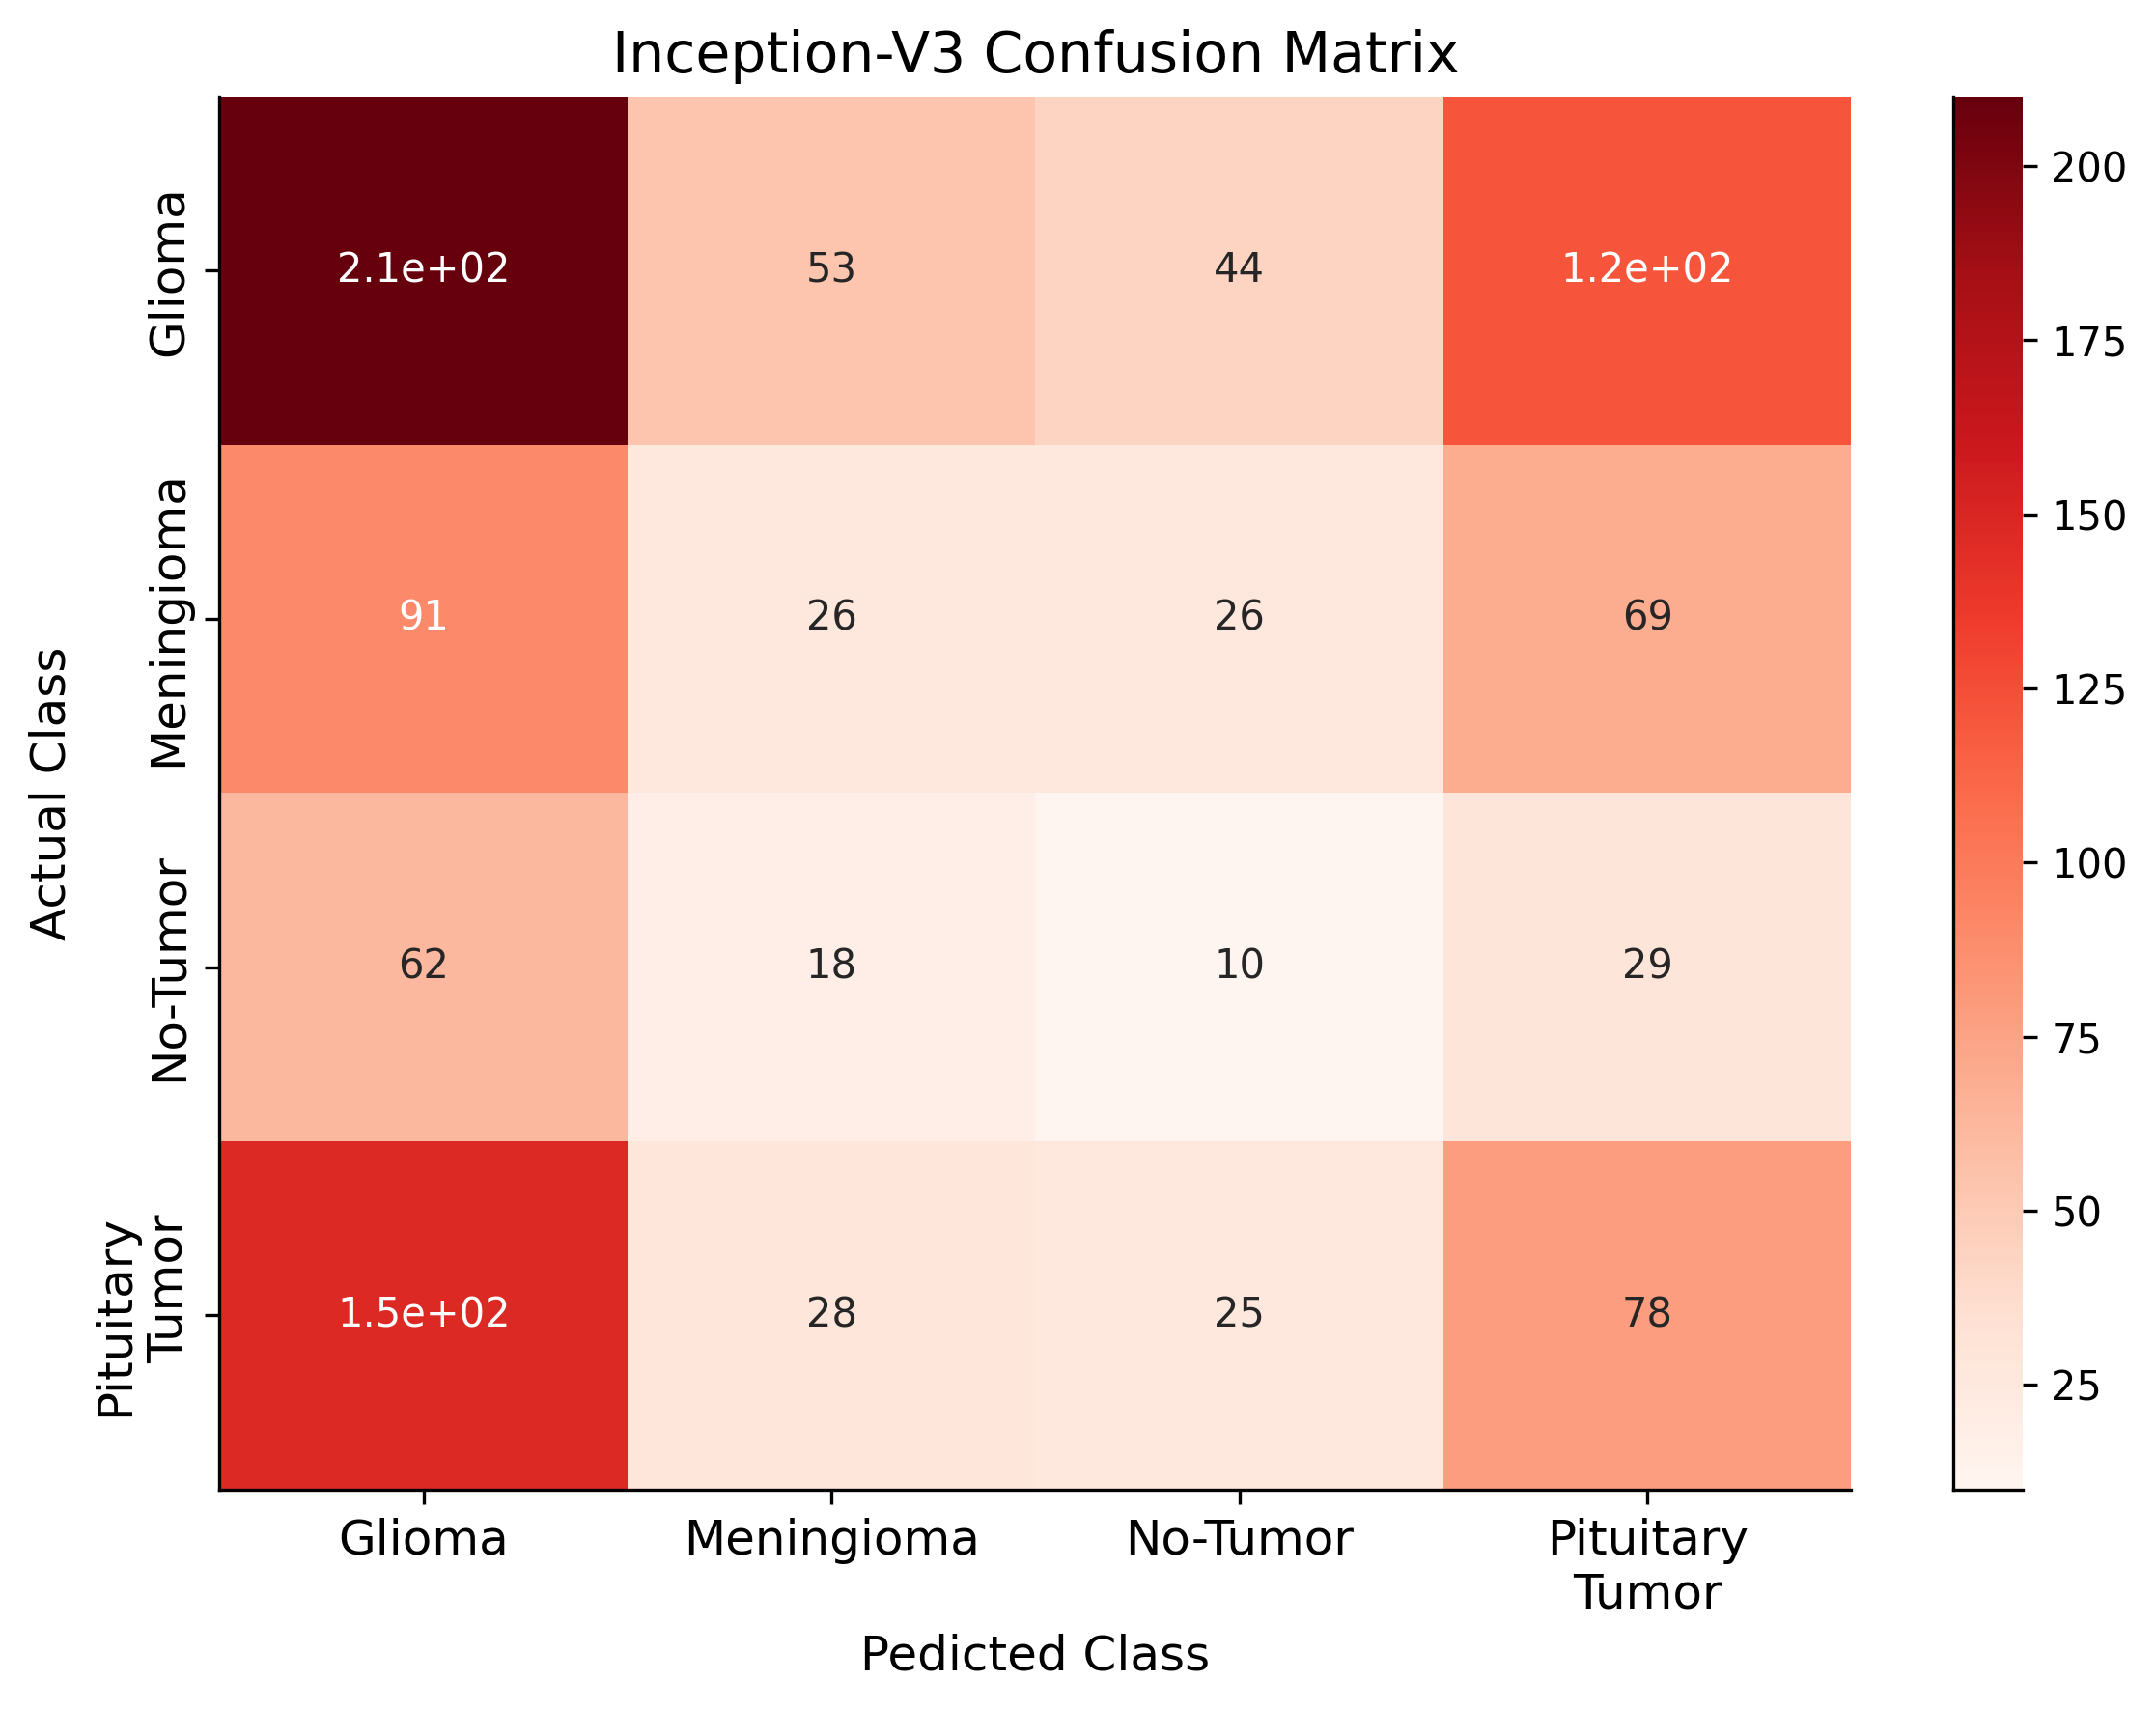

In [42]:
confusion_matrix_viz(inception_cnn_model,
                         test_dataset,
                         plot_title = "Inception-V3 Confusion Matrix")

In [ ]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])

In [46]:
display(inceptionv3_report_df)

Macro Precision  Micro Precision  Weighted Precision  \
InceptionV3          0.25817         0.318882            0.302984   

             Macro Recall  Micro Recall  Weighted Recall  Macro F1-Score  \
InceptionV3      0.254111      0.318882         0.318882        0.251375   

             Micro F1-Score  Weighted F1-Score  Cohen's Kappa  Log Loss  
InceptionV3        0.318882           0.306323          0.003  3.600407

In [ ]:
save_model_weights(inception_cnn_model, INCEPTIONV3_CHECKPOINT_DIR_PATH)

## **9. Conclusions**

* The **pre-trained (imagenet) InceptionV3** model has performed the best among Multi-Layer perceptron and AlexNet CNN models with an accuracy of $82.57\%$ (Refer the following table).

In [44]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, inceptionv3_report_df])
display(final_report_df)

Macro Precision  Micro Precision  \
Multi-Layer-Perceptron Model         0.193459         0.319846   
AlexNet CNN                          0.186801         0.333333   
InceptionV3                          0.258170         0.318882   

                              Weighted Precision  Macro Recall  Micro Recall  \
Multi-Layer-Perceptron Model            0.245528      0.235597      0.319846   
AlexNet CNN                             0.245808      0.236837      0.333333   
InceptionV3                             0.302984      0.254111      0.318882   

                              Weighted Recall  Macro F1-Score  Micro F1-Score  \
Multi-Layer-Perceptron Model         0.319846        0.198146        0.319846   
AlexNet CNN                          0.333333        0.203208        0.333333   
InceptionV3                          0.318882        0.251375        0.318882   

                              Weighted F1-Score  Cohen's Kappa  Log Loss  
Multi-Layer-Perceptron Model           0.269918      -0.026952  1.977685  
AlexNet CNN                            0.276177      -0.016031  3.700117  
InceptionV3                            0.306323       0.003000  3.600407

In [45]:
path = os.path.join(ROOT_DIR, "report.html")
final_report_df.to_html(path, border=1, index=True, justify="center")
print("Report saved as report.html")

Report saved as report.html
